## Importar librerias y definición de la ruta  de trabajo (path)

In [285]:
import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Formato de los prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')

In [286]:
# Ingresa la ruta donde está el repositorio
ruta = 'c:/repo_remoto/'

# Limpieza y Preprocesamiento de Datos con Python

### Cargar archivos

In [5]:
### Características Equipos

equipos = pd.read_csv(ruta + 'etapa3/data/Caracteristicas_Equipos.csv')
equipos_df = pd.DataFrame(equipos)

In [6]:
### Historicos Ordenes

ordenes = pd.read_csv(ruta + 'etapa3/data/Historicos_Ordenes.csv')
ordenes_df = pd.DataFrame(ordenes)

In [7]:
### Registros Condiciones

condiciones = pd.read_csv(ruta + 'etapa3/data/Registros_Condiciones.csv')
condiciones_df = pd.DataFrame(condiciones)

### LIMPIEZA Y PERFILADO DE CARACTERISTICAS EQUIPOS

In [8]:
# Mostrar las primeras filas de cada dataset
equipos_df.head()

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
0,1,Compresor,Siemens,Z300,3429.0,7725
1,2,Transformador,Siemens,Y200,75.0,7390
2,3,Compresor,ABB,Z300,4526.0,5238
3,4,Compresor,GE,X100,3981.0,8933
4,5,Motor,Siemens,Y200,377.0,5978


In [9]:
# Revisar info del df
equipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Equipo                    505 non-null    int64  
 1   Tipo_Equipo                  505 non-null    object 
 2   Fabricante                   505 non-null    object 
 3   Modelo                       505 non-null    object 
 4   Potencia_kW                  505 non-null    float64
 5   Horas_Recomendadas_Revision  505 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 23.8+ KB


In [10]:
# Datos vacios
print('Datos vacios en Caracteristicas_Equipos.csv\n',equipos_df.isna().sum())

Datos vacios en Caracteristicas_Equipos.csv
 ID_Equipo                      0
Tipo_Equipo                    0
Fabricante                     0
Modelo                         0
Potencia_kW                    0
Horas_Recomendadas_Revision    0
dtype: int64


In [11]:
# Extremos
z_scores = (equipos_df-equipos_df.mean(numeric_only=True)) / \
    equipos_df.std(numeric_only=True)
z_scores_abs = z_scores.apply(np.abs)
print(tabulate(z_scores_abs, headers='keys'))

       Fabricante    Horas_Recomendadas_Revision    ID_Equipo    Modelo    Potencia_kW    Tipo_Equipo
---  ------------  -----------------------------  -----------  --------  -------------  -------------
  0           nan                     0.894663    1.69396           nan    0.095438               nan
  1           nan                     0.771925    1.68711           nan    0.352659               nan
  2           nan                     0.0165308   1.68025           nan    0.0113082              nan
  3           nan                     1.33725     1.67339           nan    0.0531047              nan
  4           nan                     0.254593    1.66654           nan    0.329498               nan
  5           nan                     0.070389    1.65968           nan    0.32597                nan
  6           nan                     0.874599    1.65282           nan    0.185933               nan
  7           nan                     0.633519    1.64597           nan    0.08178

In [12]:
umbral = 3

out_mask = ~z_scores[z_scores_abs > umbral].isna()
print('\nOutliers per column:\n')
print(out_mask.sum())


Outliers per column:

Fabricante                      0
Horas_Recomendadas_Revision     0
ID_Equipo                       0
Modelo                          0
Potencia_kW                    15
Tipo_Equipo                     0
dtype: int64


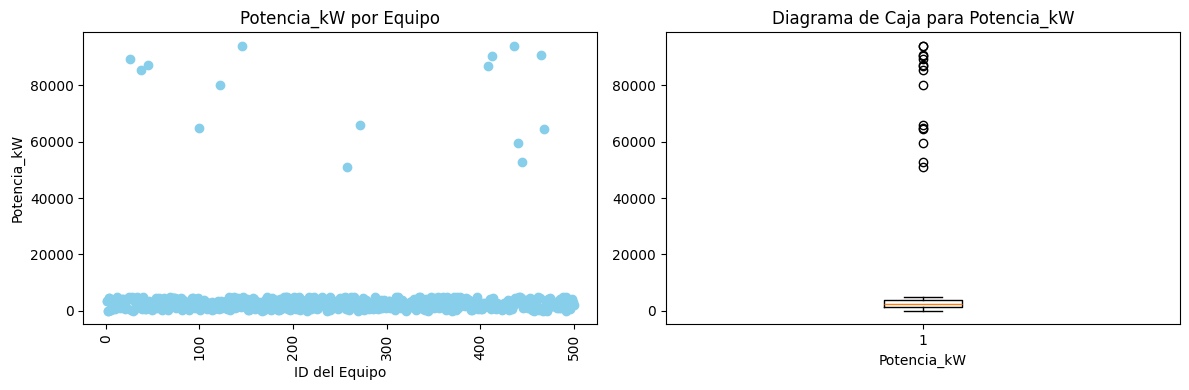

In [13]:
# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar la Potencia_kW por equipo
axes[0].scatter(equipos_df['ID_Equipo'], equipos_df['Potencia_kW'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Potencia_kW')
axes[0].set_title('Potencia_kW por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Potencia_kW
axes[1].boxplot(equipos_df['Potencia_kW'], vert=True)
axes[1].set_xlabel('Potencia_kW')
axes[1].set_title('Diagrama de Caja para Potencia_kW')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [14]:
# Reemplazar los valores de outliers con la media de las filas que coincidan en Fabricante, Modelo y Tipo_Equipo

# Filtrar filas con outliers en Potencia_kW
outliers_potencia = equipos_df[(z_scores_abs['Potencia_kW'] > umbral)]

for index, row in outliers_potencia.iterrows():
    # Filtrar filas coincidentes
    coincidencias = equipos_df[
        (equipos_df['Fabricante'] == row['Fabricante']) &
        (equipos_df['Modelo'] == row['Modelo']) &
        (equipos_df['Tipo_Equipo'] == row['Tipo_Equipo']) &
        (z_scores_abs['Potencia_kW'] <= umbral)  # Excluir otros outliers
    ]
    if not coincidencias.empty:
        # Calcular la media de Potencia_kW para las coincidencias
        media_potencia = coincidencias['Potencia_kW'].mean()
        # Reemplazar el valor del outlier con la media calculada
        equipos_df.at[index, 'Potencia_kW'] = media_potencia

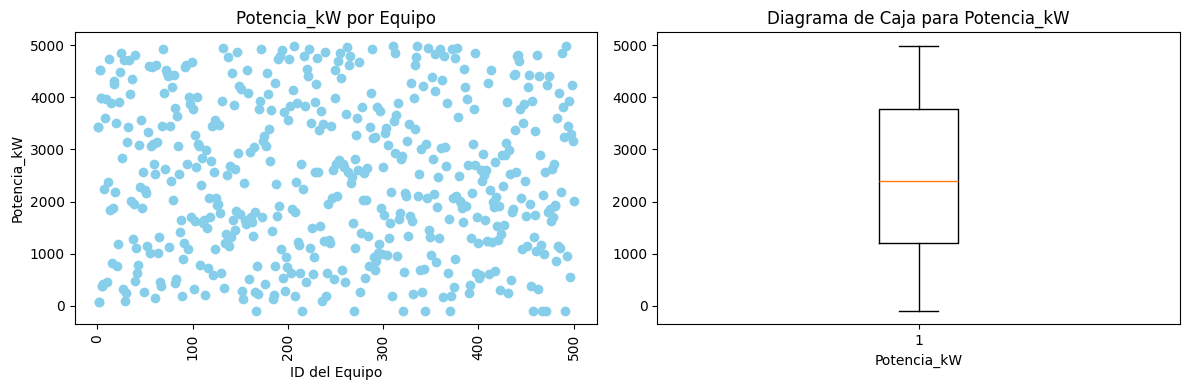

In [15]:

# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar la Potencia_kW por equipo
axes[0].scatter(equipos_df['ID_Equipo'], equipos_df['Potencia_kW'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Potencia_kW')
axes[0].set_title('Potencia_kW por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Potencia_kW
axes[1].boxplot(equipos_df['Potencia_kW'], vert=True)
axes[1].set_xlabel('Potencia_kW')
axes[1].set_title('Diagrama de Caja para Potencia_kW')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [16]:
# Mostrar todas las filas duplicadas
print('\nSumatorio duplicados en equipos_df', equipos_df.duplicated().sum())
equipos_df[equipos_df.duplicated(keep=False)]


Sumatorio duplicados en equipos_df 5


,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
0,1,Compresor,Siemens,Z300,3429.0,7725
1,2,Transformador,Siemens,Y200,75.0,7390
2,3,Compresor,ABB,Z300,4526.0,5238
3,4,Compresor,GE,X100,3981.0,8933
4,5,Motor,Siemens,Y200,377.0,5978
500,1,Compresor,Siemens,Z300,3429.0,7725
501,2,Transformador,Siemens,Y200,75.0,7390
502,3,Compresor,ABB,Z300,4526.0,5238
503,4,Compresor,GE,X100,3981.0,8933
504,5,Motor,Siemens,Y200,377.0,5978


In [17]:
# Elimino filas duplicadas ya que no aportan nada

equipos_df_clean = equipos_df.drop_duplicates(keep='first')
print('\nSumatorio duplicados en equipos_df:', equipos_df_clean.duplicated().sum())



Sumatorio duplicados en equipos_df: 0


In [18]:
equipos_df_clean

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
0,1,Compresor,Siemens,Z300,3429.0,7725
1,2,Transformador,Siemens,Y200,75.0,7390
2,3,Compresor,ABB,Z300,4526.0,5238
3,4,Compresor,GE,X100,3981.0,8933
4,5,Motor,Siemens,Y200,377.0,5978
...,...,...,...,...,...,...
495,496,Transformador,Schneider,Z300,544.0,3331
496,497,Compresor,GE,M400,3296.0,8256
497,498,Generador,Siemens,X100,4231.0,9047
498,499,Motor,Siemens,Y200,3155.0,932


In [19]:
equipos_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Equipo                    500 non-null    int64  
 1   Tipo_Equipo                  500 non-null    object 
 2   Fabricante                   500 non-null    object 
 3   Modelo                       500 non-null    object 
 4   Potencia_kW                  500 non-null    float64
 5   Horas_Recomendadas_Revision  500 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 27.3+ KB


In [20]:
# Cardinalidad

# Calcular el sumatorio de valores para cada columna
sum_value_equipos = equipos_df_clean.count()

# Calcular el sumatorio de valores únicos para cada columna
unique_sum_equipos = equipos_df_clean.nunique()

# Crear un nuevo DataFrame para mostrar ambos sumatorios
result_df_equipos = pd.DataFrame({
    'Sumatorio de valores': sum_value_equipos,
    'Sumatorio de valores únicos': unique_sum_equipos
})

print(result_df_equipos)

                             Sumatorio de valores  Sumatorio de valores únicos
ID_Equipo                                     500                          500
Tipo_Equipo                                   500                            4
Fabricante                                    500                            4
Modelo                                        500                            4
Potencia_kW                                   500                          468
Horas_Recomendadas_Revision                   500                          488


In [21]:
# Columnas a 'category'

equipos_df_clean[['Tipo_Equipo', 'Fabricante', 'Modelo']] = equipos_df_clean[[
    'Tipo_Equipo', 'Fabricante', 'Modelo']].astype('category')

equipos_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ID_Equipo                    500 non-null    int64   
 1   Tipo_Equipo                  500 non-null    category
 2   Fabricante                   500 non-null    category
 3   Modelo                       500 non-null    category
 4   Potencia_kW                  500 non-null    float64 
 5   Horas_Recomendadas_Revision  500 non-null    int64   
dtypes: category(3), float64(1), int64(2)
memory usage: 17.7 KB


In [22]:
equipos_df_clean.describe()

,ID_Equipo,Potencia_kW,Horas_Recomendadas_Revision
count,500.000000,500.000000,500.000000
mean,250.500000,2460.886575,5265.422000
std,144.481833,1474.523485,2734.111346
min,1.000000,-100.000000,509.000000
25%,125.750000,1207.500000,2920.750000
50%,250.500000,2392.500000,5209.500000
75%,375.250000,3778.000000,7658.000000
max,500.000000,4990.000000,9988.000000


In [23]:
equipos_df_clean.describe(include='category')

,Tipo_Equipo,Fabricante,Modelo
count,500,500,500
unique,4,4,4
top,Compresor,ABB,Y200
freq,127,134,141


In [24]:
# Existen equipos con Potencia menor de 0

print("\nEquipos con potencia <0 kW:", len(equipos_df_clean[equipos_df_clean['Potencia_kW'] < 0]))
equipos_df_clean[equipos_df_clean['Potencia_kW'] < 0]


Equipos con potencia <0 kW: 10


,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
166,167,Transformador,ABB,Z300,-100.0,9737
214,215,Motor,Schneider,Y200,-100.0,1243
268,269,Compresor,ABB,Y200,-100.0,3636
320,321,Compresor,Siemens,M400,-100.0,5055
343,344,Generador,Schneider,Z300,-100.0,6729
369,370,Transformador,GE,M400,-100.0,917
456,457,Compresor,ABB,X100,-100.0,3496
466,467,Compresor,GE,X100,-100.0,5794
470,471,Transformador,Siemens,Z300,-100.0,4985
490,491,Generador,ABB,Y200,-100.0,2499


In [25]:
# Busco filas que tengan el mismo Tipo_Equipo + Fabricante + Modelo que la fila con Potencia_kW <0 y además muestro al final su sumatorio

# Filtrar filas con Costo_Mantenimiento vacío
filas_pot = equipos_df_clean[equipos_df_clean['Potencia_kW'] < 0]

# Inicializar contador de coincidencias
pot_coincidencias = 0

# Buscar coincidencias en todo el DataFrame
for index, row in filas_pot.iterrows():
    coincidencias4 = equipos_df_clean[(equipos_df_clean['Tipo_Equipo'] == row['Tipo_Equipo']) &
                                      (equipos_df_clean['Fabricante'] == row['Fabricante']) & 
                               (equipos_df_clean['Modelo'] == row['Modelo'])]
    if len(coincidencias4) > 1:
        print(tabulate(coincidencias4, headers='keys'))
        pot_coincidencias += 1

# Mostrar el sumatorio de las filas NaN que han coincidido
print(f'\nSumatorio de filas NaN que han coincidido: {pot_coincidencias}')

       ID_Equipo  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
---  -----------  -------------  ------------  --------  -------------  -----------------------------
 93           94  Transformador  ABB           Z300               2727                           6994
166          167  Transformador  ABB           Z300               -100                           9737
172          173  Transformador  ABB           Z300               1711                           9571
203          204  Transformador  ABB           Z300               1853                           4941
232          233  Transformador  ABB           Z300               3373                           4580
316          317  Transformador  ABB           Z300               1661                           2753
336          337  Transformador  ABB           Z300               2109                           8902
       ID_Equipo  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Re

In [26]:
# Reemplazo el valor de Potencia_kW < 0 por la media de las fils con mismo Tipo_Equipo + Fabricante + Modelo

# Filtrar filas con Potencia_kW < 0
filas_pot_negativas = equipos_df_clean[equipos_df_clean['Potencia_kW'] < 0]

# Reemplazar valores negativos por la media de sus valores filtrados
for index, row in filas_pot_negativas.iterrows():
    # Filtrar filas con el mismo Tipo_Equipo, Fabricante y Modelo
    coincidencias = equipos_df_clean[(equipos_df_clean['Tipo_Equipo'] == row['Tipo_Equipo']) &
                                     (equipos_df_clean['Fabricante'] == row['Fabricante']) &
                                     (equipos_df_clean['Modelo'] == row['Modelo']) &
                                     (equipos_df_clean['Potencia_kW'] >= 0)]
    if not coincidencias.empty:
        # Calcular la media de Potencia_kW para las coincidencias
        media_potencia = coincidencias['Potencia_kW'].mean()
        # Reemplazar el valor negativo con la media calculada
        equipos_df_clean.at[index, 'Potencia_kW'] = media_potencia

# Mostrar el sumatorio de las filas con Potencia_kW <0
print(f'\nSumatorio de filas con Potencia_kW < 0 kW: {len(equipos_df_clean[equipos_df_clean["Potencia_kW"] < 0])}')


Sumatorio de filas con Potencia_kW < 0 kW: 0


In [27]:
# Value_counts te muestra cuantos valores hay de cada valor único en la columna selecionada

print(equipos_df_clean[['Tipo_Equipo', 'Fabricante', 'Modelo']].value_counts())

Tipo_Equipo    Fabricante  Modelo
Compresor      GE          X100      13
Motor          Schneider   M400      13
Compresor      Siemens     Y200      12
               Schneider   Z300      12
Transformador  GE          Y200      11
                                     ..
Motor          Schneider   X100       4
Compresor      ABB         M400       3
               Siemens     X100       3
Motor          GE          M400       3
Transformador  GE          Z300       3
Name: count, Length: 64, dtype: int64


In [28]:
# Frecuencias en equipos

for col in equipos_df_clean.columns:
    print('\n- Frecuencias para "{0}"'.format(col), '\n')
    print(equipos_df_clean[col].value_counts())


- Frecuencias para "ID_Equipo" 

ID_Equipo
500    1
1      1
2      1
3      1
484    1
      ..
9      1
8      1
7      1
6      1
5      1
Name: count, Length: 500, dtype: int64

- Frecuencias para "Tipo_Equipo" 

Tipo_Equipo
Compresor        127
Motor            125
Transformador    125
Generador        123
Name: count, dtype: int64

- Frecuencias para "Fabricante" 

Fabricante
ABB          134
Schneider    127
GE           121
Siemens      118
Name: count, dtype: int64

- Frecuencias para "Modelo" 

Modelo
Y200    141
X100    124
Z300    122
M400    113
Name: count, dtype: int64

- Frecuencias para "Potencia_kW" 

Potencia_kW
3778.0    3
4432.0    2
1626.0    2
1730.0    2
2825.0    2
         ..
1145.0    1
2374.0    1
465.0     1
3960.0    1
2249.0    1
Name: count, Length: 477, dtype: int64

- Frecuencias para "Horas_Recomendadas_Revision" 

Horas_Recomendadas_Revision
4455    3
9954    2
1751    2
6355    2
7529    2
       ..
4698    1
2921    1
4134    1
1988    1
2060    1

In [29]:
# Correlación

corr_equipos = equipos_df_clean.corr('pearson', numeric_only=True)
corr_equipos

,ID_Equipo,Potencia_kW,Horas_Recomendadas_Revision
ID_Equipo,1.000000,0.001382,-0.030918
Potencia_kW,0.001382,1.000000,-0.058764
Horas_Recomendadas_Revision,-0.030918,-0.058764,1.000000


In [30]:
# Correlación

corr_equipos[(np.abs(corr_equipos) >= 0.7) & (np.abs(corr_equipos) >= 0.7)]

,ID_Equipo,Potencia_kW,Horas_Recomendadas_Revision
ID_Equipo,1.0,NaN,NaN
Potencia_kW,NaN,1.0,NaN
Horas_Recomendadas_Revision,NaN,NaN,1.0


In [31]:
# Sesgo

skw_equipos = equipos_df_clean.skew(numeric_only=True)
skw_equipos

ID_Equipo                      0.000000
Potencia_kW                    0.093602
Horas_Recomendadas_Revision   -0.000503
dtype: float64

In [32]:
# Sesgo

skw_equipos[np.abs(skw_equipos) > 2]

Series([], dtype: float64)

In [33]:
# Kurtosis

kurt_equipos = equipos_df_clean.kurt(numeric_only=True)
kurt_equipos

ID_Equipo                     -1.200000
Potencia_kW                   -1.158448
Horas_Recomendadas_Revision   -1.251666
dtype: float64

In [34]:
# Kurtosis

kurt_equipos[np.abs(kurt_equipos) > 3]

Series([], dtype: float64)

In [35]:
# Evaluar la unicidad de posibles claves primarias

# Crear una lista para almacenar los resultados
unike_keys_equipos = []

# Iterar sobre cada columna del DataFrame
for column in equipos_df_clean.columns:
    # Verificar si la columna tiene valores únicos
    if equipos_df_clean[column].is_unique:
        unike_keys_equipos.append(column)

# Mostrar las posibles claves primarias
print("Posibles claves primarias en equipos_df_clean:")
print(unike_keys_equipos)

Posibles claves primarias en equipos_df_clean:
['ID_Equipo']


In [36]:
equipos_df_clean.describe()

,ID_Equipo,Potencia_kW,Horas_Recomendadas_Revision
count,500.000000,500.000000,500.000000
mean,250.500000,2506.256813,5265.422000
std,144.481833,1430.909984,2734.111346
min,1.000000,75.000000,509.000000
25%,125.750000,1295.500000,2920.750000
50%,250.500000,2482.000000,5209.500000
75%,375.250000,3778.000000,7658.000000
max,500.000000,4990.000000,9988.000000


In [37]:
equipos_df_clean.describe(include='category')

,Tipo_Equipo,Fabricante,Modelo
count,500,500,500
unique,4,4,4
top,Compresor,ABB,Y200
freq,127,134,141


### LIMPIEZA Y PERFILADO DE HISTORICOS ORDENES

In [38]:
# Mostrar las primeras filas de cada dataset
ordenes_df.head()

,ID_Orden,ID_Equipo,Fecha,Tipo_Mantenimiento,Costo_Mantenimiento,Duracion_Horas,Ubicacion
0,1,36,2020-01-01 00:00:00,Preventivo,6754.12,3,Planta Norte
1,2,244,2020-01-01 01:00:00,Preventivo,4274.63,35,Planta Norte
2,3,297,2020-01-01 02:00:00,Preventivo,5752.00,25,Planta Norte
3,4,431,2020-01-01 03:00:00,Correctivo,5690.14,8,Planta Sur
4,5,403,2020-01-01 04:00:00,Correctivo,7048.79,28,Planta Norte


In [39]:
# Revisar info del df
ordenes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_Orden             10020 non-null  int64  
 1   ID_Equipo            10020 non-null  int64  
 2   Fecha                10020 non-null  object 
 3   Tipo_Mantenimiento   10020 non-null  object 
 4   Costo_Mantenimiento  9971 non-null   float64
 5   Duracion_Horas       10020 non-null  int64  
 6   Ubicacion            10020 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 548.1+ KB


In [40]:
# Datos vacios
print('Datos vacios en Historicos_Ordenes.csv\n',ordenes_df.isna().sum())

Datos vacios en Historicos_Ordenes.csv
 ID_Orden                0
ID_Equipo               0
Fecha                   0
Tipo_Mantenimiento      0
Costo_Mantenimiento    49
Duracion_Horas          0
Ubicacion               0
dtype: int64


In [41]:
# Busco filas que tengan el mismo ID_Equipo + Duracion_Horas que la fila con Costo_Mantenimiento vacío y además muestro al final su sumatorio

# Filtrar filas con Costo_Mantenimiento vacío
filas_vacias = ordenes_df[ordenes_df['Costo_Mantenimiento'].isna()]

# Inicializar contador de coincidencias
nan_coincidencias = 0

# Buscar coincidencias en todo el DataFrame
for index, row in filas_vacias.iterrows():
    coincidencias1 = ordenes_df[(ordenes_df['ID_Equipo'] == row['ID_Equipo']) & 
                               (ordenes_df['Duracion_Horas'] == row['Duracion_Horas'])]
    if len(coincidencias1) > 1:
        print(tabulate(coincidencias1, headers='keys'))
        nan_coincidencias += 1

# Mostrar el sumatorio de las filas NaN que han coincidido
print(f'\nSumatorio de filas NaN que han coincidido: {nan_coincidencias}')

        ID_Orden    ID_Equipo  Fecha                Tipo_Mantenimiento      Costo_Mantenimiento    Duracion_Horas  Ubicacion
----  ----------  -----------  -------------------  --------------------  ---------------------  ----------------  ------------
 580         581          254  2020-01-25 04:00:00  Correctivo                           nan                   14  Planta Oeste
4311        4312          254  2020-06-28 15:00:00  Correctivo                          7764.35                14  Planta Este
        ID_Orden    ID_Equipo  Fecha                Tipo_Mantenimiento      Costo_Mantenimiento    Duracion_Horas  Ubicacion
----  ----------  -----------  -------------------  --------------------  ---------------------  ----------------  ------------
 847         848          194  2020-02-05 07:00:00  Preventivo                           nan                   41  Planta Oeste
6479        6480          194  2020-09-26 23:00:00  Correctivo                          1972.62                

In [42]:
# Primero sustituyo el valor de Costo_Mantenimiento vacío por el valor de la línea que coincida con ID_Equipo + Duración_Horas + Ubicación

ordenes_df_clean = pd.DataFrame(ordenes_df)

# Filtrar filas con Costo_Mantenimiento vacío
filas_vacias = ordenes_df_clean[ordenes_df_clean['Costo_Mantenimiento'].isna()]

# Buscar coincidencias en todo el DataFrame y reemplazar valores vacíos
for index, row in filas_vacias.iterrows():
    coincidencias2 = ordenes_df_clean[(ordenes_df_clean['ID_Equipo'] == row['ID_Equipo']) & 
                                (ordenes_df_clean['Duracion_Horas'] == row['Duracion_Horas']) &
                                (ordenes_df_clean['Ubicacion'] == row['Ubicacion']) & 
                                (ordenes_df_clean['Costo_Mantenimiento'].notna())]
    if not coincidencias2.empty:
        # Reemplazar el valor vacío en ordenes_df_clean con el valor de la primera coincidencia encontrada
        ordenes_df_clean.at[index, 'Costo_Mantenimiento'] = coincidencias2.iloc[0]['Costo_Mantenimiento']


In [43]:
# Segundo sustituyo el valor de Costo_Mantenimiento vacío por el valor de la línea que coincida ID_Equipo + Duración_Horas

# Filtrar filas con Costo_Mantenimiento vacío
filas_vacias = ordenes_df_clean[ordenes_df_clean['Costo_Mantenimiento'].isna()]

# Buscar coincidencias en todo el DataFrame y reemplazar valores vacíos
for index, row in filas_vacias.iterrows():
    coincidencias3 = ordenes_df_clean[(ordenes_df_clean['ID_Equipo'] == row['ID_Equipo']) & 
                               (ordenes_df_clean['Duracion_Horas'] == row['Duracion_Horas']) &
                               (ordenes_df_clean['Costo_Mantenimiento'].notna())]
    if not coincidencias3.empty:
        # Reemplazar el valor vacío con el valor de la primera coincidencia encontrada
        ordenes_df_clean.at[index, 'Costo_Mantenimiento'] = coincidencias3.iloc[0]['Costo_Mantenimiento']



In [44]:
# Vuelvo a revisar los datos vacíos donde ya he sustituidos los anteriores reduciendo a 33 los valores vacíos
print('Datos vacios en Historicos_Ordenes.csv\n',ordenes_df_clean.isna().sum())

Datos vacios en Historicos_Ordenes.csv
 ID_Orden                0
ID_Equipo               0
Fecha                   0
Tipo_Mantenimiento      0
Costo_Mantenimiento    27
Duracion_Horas          0
Ubicacion               0
dtype: int64


In [45]:
# Sustituyo valores vacíos por su media

# Calcular la media de la columna Costo_Mantenimiento
mean_costo_mantenimiento = ordenes_df_clean['Costo_Mantenimiento'].mean()

# Sustituir los valores vacíos por la media
ordenes_df_clean['Costo_Mantenimiento'].fillna(mean_costo_mantenimiento, inplace=True)

# Vuelvo a revisar los datos vacíos donde ya he sustituidos los anteriores reduciendo en 17 los valores vacíos
print('Datos vacios en Historicos_Ordenes.csv\n',ordenes_df_clean.isna().sum())

Datos vacios en Historicos_Ordenes.csv
 ID_Orden               0
ID_Equipo              0
Fecha                  0
Tipo_Mantenimiento     0
Costo_Mantenimiento    0
Duracion_Horas         0
Ubicacion              0
dtype: int64


In [46]:
# Extremos
z_scores = (ordenes_df_clean-ordenes_df_clean.mean(numeric_only=True)) / \
    ordenes_df_clean.std(numeric_only=True)
z_scores_abs = z_scores.apply(np.abs)
print(tabulate(z_scores_abs, headers='keys'))

         Costo_Mantenimiento    Duracion_Horas    Fecha    ID_Equipo     ID_Orden    Tipo_Mantenimiento    Ubicacion
-----  ---------------------  ----------------  -------  -----------  -----------  --------------------  -----------
    0            0.318874           1.54197         nan   1.4829      1.72493                       nan          nan
    1            0.208826           0.813876        nan   0.0367262   1.72459                       nan          nan
    2            0.105597           0.0776758       nan   0.331771    1.72424                       nan          nan
    3            0.0924315          1.17387         nan   1.26344     1.7239                        nan          nan
    4            0.381588           0.298536        nan   1.06876     1.72355                       nan          nan
    5            0.795158           1.18198         nan   1.58327     1.7232                        nan          nan
    6            0.828412           0.961116        nan   0.5125

In [47]:
umbral = 3

out_mask = ~z_scores[z_scores_abs > umbral].isna()
print('\nOutliers per column:\n')
print(out_mask.sum())


Outliers per column:

Costo_Mantenimiento    30
Duracion_Horas          0
Fecha                   0
ID_Equipo               0
ID_Orden                0
Tipo_Mantenimiento      0
Ubicacion               0
dtype: int64


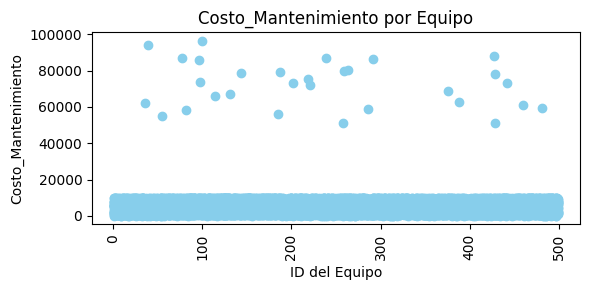

In [48]:

# Crear un gráfico de dispersión para mostrar la Costo_Mantenimiento por equipo
plt.figure(figsize=(6, 3))
plt.scatter(ordenes_df_clean['ID_Equipo'], ordenes_df_clean['Costo_Mantenimiento'], color='skyblue')
plt.xlabel('ID del Equipo')
plt.ylabel('Costo_Mantenimiento')
plt.title('Costo_Mantenimiento por Equipo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt


In [49]:
# Calcular la media de la columna Costo_Mantenimiento sin incluir los outliers
mean_costo_mantenimiento = ordenes_df_clean.loc[z_scores_abs['Costo_Mantenimiento'] <= umbral, 'Costo_Mantenimiento'].mean()

# Reemplazar los outliers por la media calculada
ordenes_df_clean.loc[z_scores_abs['Costo_Mantenimiento'] > umbral, 'Costo_Mantenimiento'] = mean_costo_mantenimiento



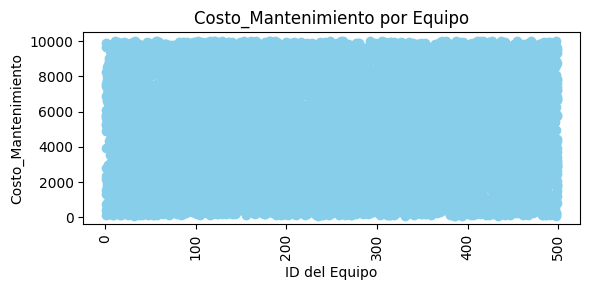

In [50]:

# Crear un gráfico de dispersión para mostrar la Costo_Mantenimiento por equipo
plt.figure(figsize=(6, 3))
plt.scatter(ordenes_df_clean['ID_Equipo'], ordenes_df_clean['Costo_Mantenimiento'], color='skyblue')
plt.xlabel('ID del Equipo')
plt.ylabel('Costo_Mantenimiento')
plt.title('Costo_Mantenimiento por Equipo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt


In [51]:
# Vuelvo a revisar info del df
ordenes_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_Orden             10020 non-null  int64  
 1   ID_Equipo            10020 non-null  int64  
 2   Fecha                10020 non-null  object 
 3   Tipo_Mantenimiento   10020 non-null  object 
 4   Costo_Mantenimiento  10020 non-null  float64
 5   Duracion_Horas       10020 non-null  int64  
 6   Ubicacion            10020 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 548.1+ KB


In [52]:
# Mostrar todas las filas duplicadas
print('\nSumatorio duplicados en ordenes', ordenes_df_clean.duplicated().sum())
ordenes_df_clean[ordenes_df_clean.duplicated(keep=False)]


Sumatorio duplicados en ordenes 20


,ID_Orden,ID_Equipo,Fecha,Tipo_Mantenimiento,Costo_Mantenimiento,Duracion_Horas,Ubicacion
0,1,36,2020-01-01 00:00:00,Preventivo,6754.12,3,Planta Norte
1,2,244,2020-01-01 01:00:00,Preventivo,4274.63,35,Planta Norte
2,3,297,2020-01-01 02:00:00,Preventivo,5752.00,25,Planta Norte
3,4,431,2020-01-01 03:00:00,Correctivo,5690.14,8,Planta Sur
4,5,403,2020-01-01 04:00:00,Correctivo,7048.79,28,Planta Norte
5,6,477,2020-01-01 05:00:00,Correctivo,1519.65,40,Planta Norte
6,7,323,2020-01-01 06:00:00,Correctivo,9148.27,37,Planta Sur
7,8,318,2020-01-01 07:00:00,Correctivo,7784.49,19,Planta Sur
8,9,154,2020-01-01 08:00:00,Preventivo,4968.19,25,Planta Sur
9,10,286,2020-01-01 09:00:00,Correctivo,8351.02,21,Planta Este


In [53]:
# Elimino filas duplicadas una vez las he analizado

ordenes_df_cleaned = ordenes_df_clean.drop_duplicates(keep='first')
print('\nSumatorio duplicados en ordenes_df_clean:', ordenes_df_cleaned.duplicated().sum())


Sumatorio duplicados en ordenes_df_clean: 0


In [54]:
# Vuelvo a revisar info del df
ordenes_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_Orden             10000 non-null  int64  
 1   ID_Equipo            10000 non-null  int64  
 2   Fecha                10000 non-null  object 
 3   Tipo_Mantenimiento   10000 non-null  object 
 4   Costo_Mantenimiento  10000 non-null  float64
 5   Duracion_Horas       10000 non-null  int64  
 6   Ubicacion            10000 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 625.0+ KB


In [55]:
# Cardinalidad

# Calcular el sumatorio de valores para cada columna
sum_values_ordenes = ordenes_df_cleaned.count()

# Calcular el sumatorio de valores únicos para cada columna
unique_sum_ordenes = ordenes_df_cleaned.nunique()

# Crear un nuevo DataFrame para mostrar ambos sumatorios
result_df_ordenes = pd.DataFrame({
    'Sumatorio de valores': sum_values_ordenes,
    'Sumatorio de valores únicos': unique_sum_ordenes
})

print(result_df_ordenes)

                     Sumatorio de valores  Sumatorio de valores únicos
ID_Orden                            10000                        10000
ID_Equipo                           10000                          499
Fecha                               10000                        10000
Tipo_Mantenimiento                  10000                            2
Costo_Mantenimiento                 10000                         9873
Duracion_Horas                      10000                           47
Ubicacion                           10000                            4


In [56]:
# Columnas object a 'category'

ordenes_df_cleaned[['Tipo_Mantenimiento', 'Ubicacion']] = ordenes_df_cleaned[[
    'Tipo_Mantenimiento', 'Ubicacion']].astype('category')

# Convertir fechas a a dateTime
ordenes_df_cleaned["Fecha"] = pd.to_datetime(ordenes_df_cleaned["Fecha"], errors='coerce')

ordenes_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_Orden             10000 non-null  int64         
 1   ID_Equipo            10000 non-null  int64         
 2   Fecha                10000 non-null  datetime64[ns]
 3   Tipo_Mantenimiento   10000 non-null  category      
 4   Costo_Mantenimiento  10000 non-null  float64       
 5   Duracion_Horas       10000 non-null  int64         
 6   Ubicacion            10000 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1), int64(3)
memory usage: 488.6 KB


In [57]:
ordenes_df_cleaned.describe()

,ID_Orden,ID_Equipo,Fecha,Costo_Mantenimiento,Duracion_Horas
count,10000.00000,10000.000000,10000,10000.000000,10000.000000
mean,5000.50000,249.245900,2020-07-27 07:30:00,5054.341858,23.944500
min,1.00000,1.000000,2020-01-01 00:00:00,101.510000,1.000000
25%,2500.75000,125.000000,2020-04-14 03:45:00,2573.362500,12.000000
50%,5000.50000,248.000000,2020-07-27 07:30:00,5065.890000,24.000000
75%,7500.25000,373.250000,2020-11-08 11:15:00,7500.337500,36.000000
max,10000.00000,499.000000,2021-02-20 15:00:00,9998.080000,47.000000
std,2886.89568,143.869541,NaN,2851.798169,13.586651


In [58]:
ordenes_df_cleaned.describe(include='category')

,Tipo_Mantenimiento,Ubicacion
count,10000,10000
unique,2,4
top,Preventivo,Planta Este
freq,5027,2544


In [59]:
# Value_counts te muestra cuantos valores hay de cada valor único en la columna selecionada

print(ordenes_df_cleaned[['Tipo_Mantenimiento', 'Ubicacion']].value_counts())

Tipo_Mantenimiento  Ubicacion   
Correctivo          Planta Sur      1283
Preventivo          Planta Este     1279
Correctivo          Planta Este     1265
Preventivo          Planta Sur      1261
                    Planta Oeste    1244
                    Planta Norte    1243
Correctivo          Planta Oeste    1222
                    Planta Norte    1203
Name: count, dtype: int64


In [60]:
# Frecuencias en ordenes

for col in ordenes_df_cleaned.columns:
    print('\n- Frecuencias para "{0}"'.format(col), '\n')
    print(ordenes_df_cleaned[col].value_counts())


- Frecuencias para "ID_Orden" 

ID_Orden
9984    1
9983    1
9982    1
9981    1
9980    1
       ..
5       1
4       1
3       1
2       1
1       1
Name: count, Length: 10000, dtype: int64

- Frecuencias para "ID_Equipo" 

ID_Equipo
236    33
233    33
150    30
107    30
165    30
       ..
190    10
81     10
270    10
184     9
177     9
Name: count, Length: 499, dtype: int64

- Frecuencias para "Fecha" 

Fecha
2021-02-19 23:00:00    1
2021-02-19 22:00:00    1
2021-02-19 21:00:00    1
2021-02-19 20:00:00    1
2021-02-19 19:00:00    1
                      ..
2020-01-01 04:00:00    1
2020-01-01 03:00:00    1
2020-01-01 02:00:00    1
2020-01-01 01:00:00    1
2020-01-01 00:00:00    1
Name: count, Length: 10000, dtype: int64

- Frecuencias para "Tipo_Mantenimiento" 

Tipo_Mantenimiento
Preventivo    5027
Correctivo    4973
Name: count, dtype: int64

- Frecuencias para "Costo_Mantenimiento" 

Costo_Mantenimiento
5054.724115    30
5255.835064    27
1065.120000     2
6754.120000     2


In [61]:
# Correlación

corr_ordenes = ordenes_df_cleaned.corr('pearson', numeric_only=True)
corr_ordenes

,ID_Orden,ID_Equipo,Costo_Mantenimiento,Duracion_Horas
ID_Orden,1.000000,0.010184,0.003388,0.012285
ID_Equipo,0.010184,1.000000,-0.026554,0.013896
Costo_Mantenimiento,0.003388,-0.026554,1.000000,-0.004940
Duracion_Horas,0.012285,0.013896,-0.004940,1.000000


In [62]:
# Correlación

corr_ordenes[(np.abs(corr_ordenes) >= 0.7) & (np.abs(corr_ordenes) >= 0.7)]

,ID_Orden,ID_Equipo,Costo_Mantenimiento,Duracion_Horas
ID_Orden,1.0,NaN,NaN,NaN
ID_Equipo,NaN,1.0,NaN,NaN
Costo_Mantenimiento,NaN,NaN,1.0,NaN
Duracion_Horas,NaN,NaN,NaN,1.0


In [63]:
# Sesgo

skw_ordenes = ordenes_df_cleaned.skew(numeric_only=True)
skw_ordenes

ID_Orden               0.000000
ID_Equipo              0.006755
Costo_Mantenimiento   -0.018948
Duracion_Horas        -0.003928
dtype: float64

In [64]:
# Sesgo

skw_ordenes[np.abs(skw_ordenes) > 2]

Series([], dtype: float64)

In [65]:
# Kurtosis

kurt_ordenes = ordenes_df_cleaned.kurt(numeric_only=True)
kurt_ordenes

ID_Orden              -1.200000
ID_Equipo             -1.202716
Costo_Mantenimiento   -1.186745
Duracion_Horas        -1.192135
dtype: float64

In [66]:
# Kurtosis

kurt_ordenes[np.abs(kurt_ordenes) > 3]

Series([], dtype: float64)

In [67]:
# Evaluar la unicidad de posibles claves primarias

# Crear una lista para almacenar los resultados
unike_keys_ordenes = []

# Iterar sobre cada columna del DataFrame
for column in ordenes_df_cleaned.columns:
    # Verificar si la columna tiene valores únicos
    if ordenes_df_cleaned[column].is_unique:
        unike_keys_ordenes.append(column)

# Mostrar las posibles claves primarias
print("Posibles claves primarias en ordenes_df_cleaned:")
print(unike_keys_ordenes)

Posibles claves primarias en ordenes_df_cleaned:
['ID_Orden', 'Fecha']


In [68]:
# Cálculo la frecuencia de mto por cada equipo según sea correctivo o preventivo

# Calcular la frecuencia de mantenimiento por equipo y tipo de mantenimiento
frecuencia_mantenimiento = ordenes_df_cleaned.groupby(['ID_Equipo', 'Tipo_Mantenimiento']).size().unstack(fill_value=0).reset_index()

# Renombrar las columnas para mayor claridad
frecuencia_mantenimiento.columns = ['ID_Equipo', 'Frecuencia_Correctivo', 'Frecuencia_Preventivo']

# Mostrar la tabla con cada ID_Equipo y su frecuencia de mantenimiento por tipo
frecuencia_mantenimiento

,ID_Equipo,Frecuencia_Correctivo,Frecuencia_Preventivo
0,1,8,14
1,2,14,10
2,3,7,5
3,4,8,13
4,5,8,10
...,...,...,...
494,495,8,12
495,496,8,8
496,497,13,10
497,498,10,11


### LIMPIEZA Y PERFILADO DE REGISTROS CONDICIONES

In [69]:
# Mostrar las primeras filas de cada dataset
condiciones_df.head()

,ID_Registro,ID_Equipo,Fecha,Temperatura_C,Vibracion_mm_s,Horas_Operativas
0,1,260,2020-01-01 00:00:00,101.43,1.22,71849.0
1,2,376,2020-01-01 01:00:00,118.51,2.97,49670.0
2,3,443,2020-01-01 02:00:00,76.04,2.93,33106.0
3,4,281,2020-01-01 03:00:00,97.09,3.25,31744.0
4,5,427,2020-01-01 04:00:00,139.42,4.22,78104.0


In [70]:
# Revisar info del df
condiciones_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_Registro       9000 non-null   int64  
 1   ID_Equipo         9000 non-null   int64  
 2   Fecha             9000 non-null   object 
 3   Temperatura_C     9000 non-null   float64
 4   Vibracion_mm_s    9000 non-null   float64
 5   Horas_Operativas  8960 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 422.0+ KB


In [71]:
# Datos vacios
print('Datos vacios en Caracteristicas_Equipos.csv\n',condiciones_df.isna().sum())

Datos vacios en Caracteristicas_Equipos.csv
 ID_Registro          0
ID_Equipo            0
Fecha                0
Temperatura_C        0
Vibracion_mm_s       0
Horas_Operativas    40
dtype: int64


In [72]:
# Relleno los valores vacíos de Horas_Operativas con la media de su columna una vez analizados sus valores

condiciones_df_fill = pd.DataFrame(condiciones_df)

# Calcular la media solo de las columna Horas_Operativas
mean_values_horas = condiciones_df['Horas_Operativas'].mean()

# Rellenar los valores vacíos con la media de su columna
condiciones_df_fill['Horas_Operativas'].fillna(mean_values_horas, inplace=True)

# Verificar que no queden valores vacíos
print('Datos vacios en condiciones_df_fill\n', condiciones_df_fill.isna().sum())


Datos vacios en condiciones_df_fill
 ID_Registro         0
ID_Equipo           0
Fecha               0
Temperatura_C       0
Vibracion_mm_s      0
Horas_Operativas    0
dtype: int64


In [73]:
# Extremos
z_scores = (condiciones_df_fill - condiciones_df_fill.mean(numeric_only=True)) / \
    condiciones_df_fill.std(numeric_only=True)
z_scores_abs = z_scores.apply(np.abs)
print(tabulate(z_scores_abs, headers='keys'))

        Fecha    Horas_Operativas    ID_Equipo    ID_Registro    Temperatura_C    Vibracion_mm_s
----  -------  ------------------  -----------  -------------  ---------------  ----------------
   0      nan         0.756338     0.0764717      1.73176          0.0204757         0.376453
   1      nan         0.0134997    0.880594       1.73138          0.267339          0.0510064
   2      nan         0.58844      1.34504        1.73099          0.448322          0.0412359
   3      nan         0.635715     0.222046       1.73061          0.093609          0.1194
   4      nan         0.973451     1.23413        1.73022          0.619693          0.356335
   5      nan         1.3747       1.39313        1.72984          0.0652993         0.00761661
   6      nan         0.896047     1.41393        1.72945          0.77085           0.458925
   7      nan         1.39934      0.679126       1.72907          0.177018          0.159059
   8      nan         1.01302      0.215113       1.

In [74]:
umbral = 3

out_mask = ~z_scores[z_scores_abs > umbral].isna()
print('\nOutliers per column:\n')
print(out_mask.sum())


Outliers per column:

Fecha                0
Horas_Operativas     0
ID_Equipo            0
ID_Registro          0
Temperatura_C       30
Vibracion_mm_s      25
dtype: int64


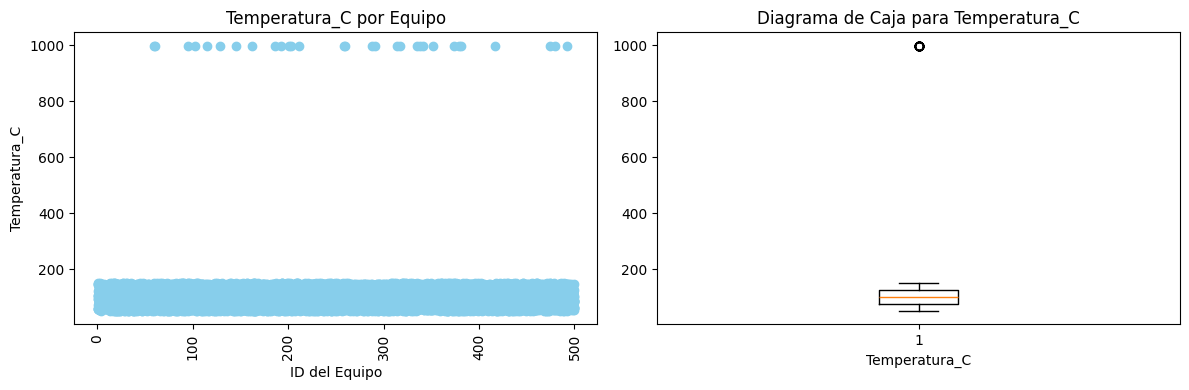

In [75]:
# Outliers Temperatura

# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar la Temperatura por equipo
axes[0].scatter(condiciones_df_fill['ID_Equipo'], condiciones_df_fill['Temperatura_C'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Temperatura_C')
axes[0].set_title('Temperatura_C por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Temperatura_C
axes[1].boxplot(condiciones_df_fill['Temperatura_C'], vert=True)
axes[1].set_xlabel('Temperatura_C')
axes[1].set_title('Diagrama de Caja para Temperatura_C')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [76]:
# Remplazo los outliers con la media de su columna después de analizar sus características.
# La medida de 999.0 puede venir dada por un fallo del equipo que provoque que la señal se vaya a fondo de escala

condiciones_df_clean = pd.DataFrame(condiciones_df_fill)

# Calcular la media de la columna Temperatura_C
mean_temperatura = condiciones_df_clean['Temperatura_C'].mean()

# Reemplazar los outliers por la media
condiciones_df_clean.loc[(z_scores_abs['Temperatura_C'] > umbral), 'Temperatura_C'] = mean_temperatura


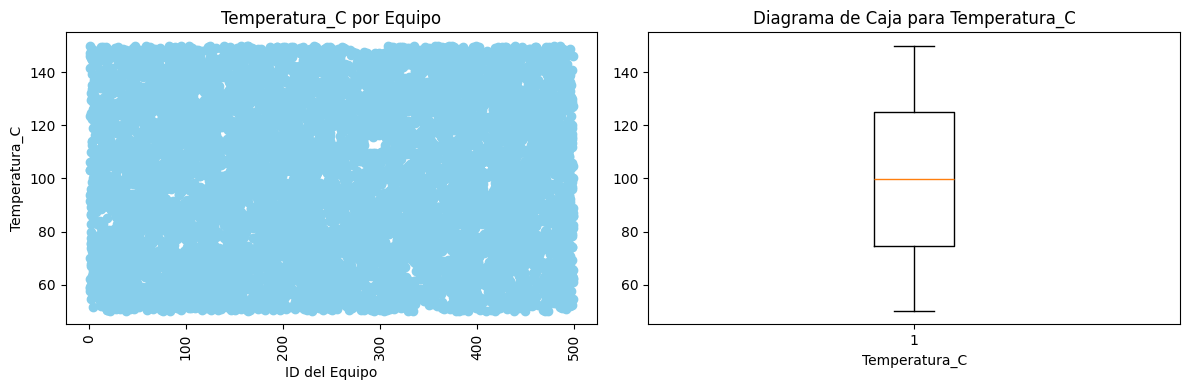

In [77]:
# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar la Temperatura por equipo
axes[0].scatter(condiciones_df_clean['ID_Equipo'], condiciones_df_clean['Temperatura_C'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Temperatura_C')
axes[0].set_title('Temperatura_C por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Temperatura_C
axes[1].boxplot(condiciones_df_clean['Temperatura_C'], vert=True)
axes[1].set_xlabel('Temperatura_C')
axes[1].set_title('Diagrama de Caja para Temperatura_C')

# Ajustar el diseño
plt.tight_layout()
plt.show()

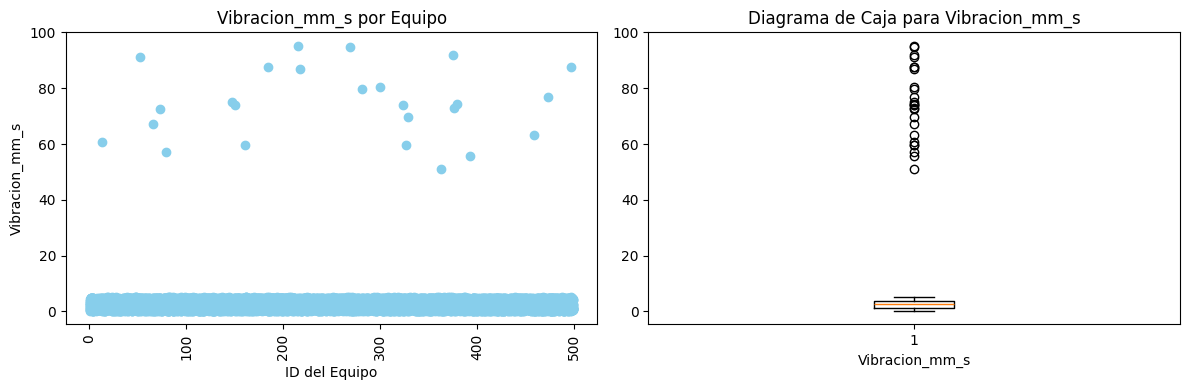

In [78]:
# Outliers Vibraciones

# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar las vibraciones por equipo
axes[0].scatter(condiciones_df_clean['ID_Equipo'], condiciones_df_clean['Vibracion_mm_s'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Vibracion_mm_s')
axes[0].set_title('Vibracion_mm_s por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Vibracion_mm_s
axes[1].boxplot(condiciones_df_clean['Vibracion_mm_s'], vert=True)
axes[1].set_xlabel('Vibracion_mm_s')
axes[1].set_title('Diagrama de Caja para Vibracion_mm_s')

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [79]:
# Remplazo los outliers con la media de su columna después de analizar sus características.
# La medida de outliers son 25 valores muy alejados del valor superior 5 mm_s, esto puede venir dado por un fallo de la medida del equipo

condiciones_df_cleaned = pd.DataFrame(condiciones_df_clean)

# Calcular la media de la columna Vibracion_mm_s
mean_temperatura = condiciones_df_cleaned['Vibracion_mm_s'].mean()

# Reemplazar los outliers por la media
condiciones_df_cleaned.loc[(z_scores_abs['Vibracion_mm_s'] > umbral), 'Vibracion_mm_s'] = mean_temperatura


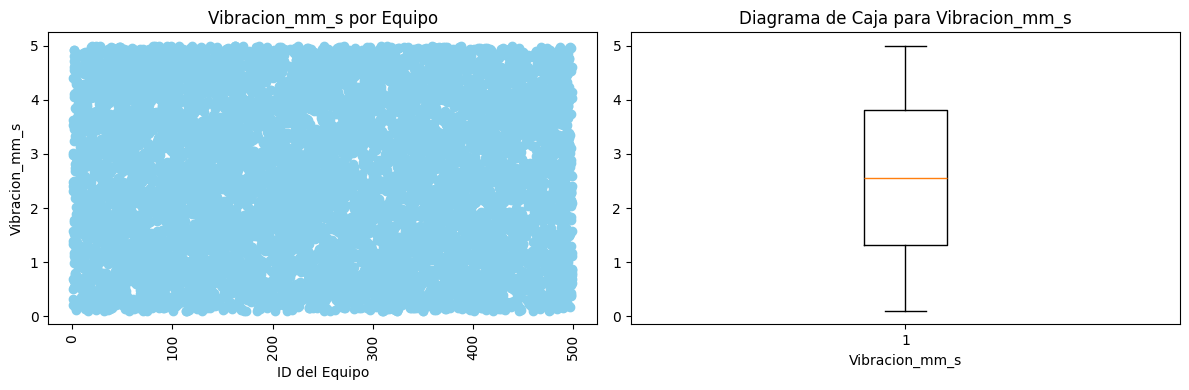

In [80]:
# Crear un lienzo con dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de dispersión para mostrar la Vibracion_mm_s por equipo
axes[0].scatter(condiciones_df_cleaned['ID_Equipo'], condiciones_df_cleaned['Vibracion_mm_s'], color='skyblue')
axes[0].set_xlabel('ID del Equipo')
axes[0].set_ylabel('Vibracion_mm_s')
axes[0].set_title('Vibracion_mm_s por Equipo')
axes[0].tick_params(axis='x', rotation=90)

# Diagrama de caja para las Vibracion_mm_s
axes[1].boxplot(condiciones_df_cleaned['Vibracion_mm_s'], vert=True)
axes[1].set_xlabel('Vibracion_mm_s')
axes[1].set_title('Diagrama de Caja para Vibracion_mm_s')

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [81]:
# Mostrar todas las filas duplicadas
print('\nSumatorio duplicados en Registros_Condiciones', condiciones_df_cleaned.duplicated().sum())
condiciones_df_cleaned[condiciones_df_cleaned.duplicated(keep=False)]


Sumatorio duplicados en Registros_Condiciones 0


,ID_Registro,ID_Equipo,Fecha,Temperatura_C,Vibracion_mm_s,Horas_Operativas


In [82]:
condiciones_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_Registro       9000 non-null   int64  
 1   ID_Equipo         9000 non-null   int64  
 2   Fecha             9000 non-null   object 
 3   Temperatura_C     9000 non-null   float64
 4   Vibracion_mm_s    9000 non-null   float64
 5   Horas_Operativas  9000 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 422.0+ KB


In [83]:
# Cardinalidad

# Calcular el sumatorio de valores para cada columna
sum_value_condiciones = condiciones_df_cleaned.count()

# Calcular el sumatorio de valores únicos para cada columna
unique_sum_condiciones = condiciones_df_cleaned.nunique()

# Crear un nuevo DataFrame para mostrar ambos sumatorios
result_df_condicones = pd.DataFrame({
    'Sumatorio de valores': sum_value_condiciones,
    'Sumatorio de valores únicos': unique_sum_condiciones
})

print(result_df_condicones)

                  Sumatorio de valores  Sumatorio de valores únicos
ID_Registro                       9000                         9000
ID_Equipo                         9000                          499
Fecha                             9000                         9000
Temperatura_C                     9000                         5909
Vibracion_mm_s                    9000                          492
Horas_Operativas                  9000                         8575


In [84]:
# Convertir fechas a a dateTime

condiciones_df_cleaned["Fecha"] = pd.to_datetime(condiciones_df_cleaned["Fecha"], errors='coerce')

condiciones_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_Registro       9000 non-null   int64         
 1   ID_Equipo         9000 non-null   int64         
 2   Fecha             9000 non-null   datetime64[ns]
 3   Temperatura_C     9000 non-null   float64       
 4   Vibracion_mm_s    9000 non-null   float64       
 5   Horas_Operativas  9000 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 422.0 KB


In [85]:
condiciones_df_cleaned.describe()

,ID_Registro,ID_Equipo,Fecha,Temperatura_C,Vibracion_mm_s,Horas_Operativas
count,9000.000000,9000.000000,9000,9000.000000,9000.000000,9000.000000
mean,4500.500000,248.968444,2020-07-06 11:30:00,99.657251,2.562243,50058.926674
min,1.000000,1.000000,2020-01-01 00:00:00,50.060000,0.100000,46.000000
25%,2250.750000,124.000000,2020-04-03 17:45:00,74.420000,1.320000,25041.750000
50%,4500.500000,247.000000,2020-07-06 11:30:00,99.605000,2.560000,50058.926674
75%,6750.250000,375.000000,2020-10-08 05:15:00,124.895000,3.820000,75173.750000
max,9000.000000,499.000000,2021-01-09 23:00:00,149.990000,5.000000,99991.000000
std,2598.220545,144.256714,NaN,28.883808,1.421344,28809.961391


In [86]:
# Frecuencias en condiciones

for col in condiciones_df_cleaned.columns:
    print('\n- Frecuencias para "{0}"'.format(col), '\n')
    print(condiciones_df_cleaned[col].value_counts())


- Frecuencias para "ID_Registro" 

ID_Registro
9000    1
1       1
2       1
3       1
4       1
       ..
13      1
12      1
11      1
10      1
9       1
Name: count, Length: 9000, dtype: int64

- Frecuencias para "ID_Equipo" 

ID_Equipo
443    31
208    31
493    30
162    29
479    28
       ..
9      10
253     9
44      9
344     8
275     8
Name: count, Length: 499, dtype: int64

- Frecuencias para "Fecha" 

Fecha
2021-01-09 23:00:00    1
2020-01-01 00:00:00    1
2020-01-01 01:00:00    1
2020-01-01 02:00:00    1
2020-01-01 03:00:00    1
                      ..
2020-01-01 12:00:00    1
2020-01-01 11:00:00    1
2020-01-01 10:00:00    1
2020-01-01 09:00:00    1
2020-01-01 08:00:00    1
Name: count, Length: 9000, dtype: int64

- Frecuencias para "Temperatura_C" 

Temperatura_C
102.645101    30
70.860000      6
136.920000     6
131.600000     6
83.960000      5
              ..
78.530000      1
58.500000      1
85.840000      1
114.340000     1
80.960000      1
Name: count, Length

In [87]:
# Correlación

corr_condiciones = condiciones_df_cleaned.corr('pearson', numeric_only=True)
corr_condiciones

,ID_Registro,ID_Equipo,Temperatura_C,Vibracion_mm_s,Horas_Operativas
ID_Registro,1.000000,0.015065,-0.001483,-0.011221,-0.002592
ID_Equipo,0.015065,1.000000,0.006169,-0.012559,-0.006966
Temperatura_C,-0.001483,0.006169,1.000000,-0.004453,0.002999
Vibracion_mm_s,-0.011221,-0.012559,-0.004453,1.000000,-0.004571
Horas_Operativas,-0.002592,-0.006966,0.002999,-0.004571,1.000000


In [88]:
# Correlación

corr_condiciones[(np.abs(corr_condiciones) >= 0.7) & (np.abs(corr_condiciones) >= 0.7)]

,ID_Registro,ID_Equipo,Temperatura_C,Vibracion_mm_s,Horas_Operativas
ID_Registro,1.0,NaN,NaN,NaN,NaN
ID_Equipo,NaN,1.0,NaN,NaN,NaN
Temperatura_C,NaN,NaN,1.0,NaN,NaN
Vibracion_mm_s,NaN,NaN,NaN,1.0,NaN
Horas_Operativas,NaN,NaN,NaN,NaN,1.0


In [89]:
# Sesgo

skw_condiciones = condiciones_df_cleaned.skew(numeric_only=True)
skw_condiciones

ID_Registro         0.000000
ID_Equipo           0.019789
Temperatura_C       0.019465
Vibracion_mm_s     -0.009655
Horas_Operativas   -0.014405
dtype: float64

In [90]:
# Sesgo

skw_condiciones[np.abs(skw_condiciones) > 2]

Series([], dtype: float64)

In [91]:
# Kurtosis

kurt_condiones = condiciones_df_cleaned.kurt(numeric_only=True)
kurt_condiones

ID_Registro        -1.200000
ID_Equipo          -1.211893
Temperatura_C      -1.206734
Vibracion_mm_s     -1.214009
Horas_Operativas   -1.199716
dtype: float64

In [92]:
# Kurtosis

kurt_condiones[np.abs(kurt_condiones) > 3]

Series([], dtype: float64)

In [93]:
# Evaluar la unicidad de posibles claves primarias

# Crear una lista para almacenar los resultados
unike_keys_condiciones = []

# Iterar sobre cada columna del DataFrame
for column in condiciones_df_cleaned.columns:
    # Verificar si la columna tiene valores únicos
    if condiciones_df_cleaned[column].is_unique:
        unike_keys_condiciones.append(column)

# Mostrar las posibles claves primarias
print("Posibles claves primarias en condiciones_df_cleaned:")
print(unike_keys_condiciones)

Posibles claves primarias en condiciones_df_cleaned:
['ID_Registro', 'Fecha']


In [94]:
condiciones_df_cleaned.describe()

,ID_Registro,ID_Equipo,Fecha,Temperatura_C,Vibracion_mm_s,Horas_Operativas
count,9000.000000,9000.000000,9000,9000.000000,9000.000000,9000.000000
mean,4500.500000,248.968444,2020-07-06 11:30:00,99.657251,2.562243,50058.926674
min,1.000000,1.000000,2020-01-01 00:00:00,50.060000,0.100000,46.000000
25%,2250.750000,124.000000,2020-04-03 17:45:00,74.420000,1.320000,25041.750000
50%,4500.500000,247.000000,2020-07-06 11:30:00,99.605000,2.560000,50058.926674
75%,6750.250000,375.000000,2020-10-08 05:15:00,124.895000,3.820000,75173.750000
max,9000.000000,499.000000,2021-01-09 23:00:00,149.990000,5.000000,99991.000000
std,2598.220545,144.256714,NaN,28.883808,1.421344,28809.961391


In [95]:
# Estimación de la vida útil de los equipos basada en el máximo de las horas operativas

# Agrupar por ID_Equipo y calcular la media de Horas_Operativas
vida_util_estimacion = condiciones_df_cleaned.groupby('ID_Equipo')['Horas_Operativas'].max().reset_index()

# Renombrar la columna para mayor claridad
vida_util_estimacion.columns = ['ID_Equipo', 'Vida_Util_Estimada']

# Mostrar la estimación de la vida útil
print(vida_util_estimacion)

     ID_Equipo  Vida_Util_Estimada
0            1             97100.0
1            2             99650.0
2            3             99319.0
3            4             98682.0
4            5             85905.0
..         ...                 ...
494        495             86053.0
495        496             93153.0
496        497             99846.0
497        498             96724.0
498        499             85233.0

[499 rows x 2 columns]


### EXPORTAR ARCHIVOS LIMPIOS

In [96]:
# Obtener la ruta del directorio actual
current_directory = os.getcwd()

print("La ruta del directorio actual es:", current_directory)

La ruta del directorio actual es: c:\repo_remoto\Etapa3\src


In [97]:
# Extraer los DataFrame limpios a un archivo CSV

equipos_df_clean.to_csv(ruta + 'etapa3/output/Caracteristicas_Equipos_limpio.csv', index=False)
ordenes_df_cleaned.to_csv(ruta + 'etapa3/output/Historicos_Ordenes_limpio.csv', index=False)
condiciones_df_cleaned.to_csv(ruta + 'etapa3/output/Registros_Condiciones_limpio.csv', index=False)

print("El DataFrame equipos_df_clean, ordenes_df_cleaned y condiciones_df_cleand se ha extraído a *.csv")

El DataFrame equipos_df_clean, ordenes_df_cleaned y condiciones_df_cleand se ha extraído a *.csv


# Mezcla y Combinación de Datos

### RENOMBRAR Y CONVERTIR

In [99]:
# Renombrar las columnas Fecha antes de la combinación
ordenes_df_cleaned = ordenes_df_cleaned.rename(columns={'Fecha': 'Fecha_Ordenes'})
condiciones_df_cleaned = condiciones_df_cleaned.rename(columns={'Fecha': 'Fecha_Registros'})

# Convertir las columnas Fecha a datetime
ordenes_df_cleaned['Fecha_Ordenes'] = pd.to_datetime(ordenes_df_cleaned['Fecha_Ordenes'])
condiciones_df_cleaned['Fecha_Registros'] = pd.to_datetime(condiciones_df_cleaned['Fecha_Registros'])

### MEZCLAR Y COMBINAR

In [100]:
# Combinar equipos_df_clean y ordenes_df_cleaned
mantenimiento_df = pd.merge(equipos_df_clean, ordenes_df_cleaned, on='ID_Equipo', how='left')

# Combinar el resultado anterior con condiciones_df_cleaned
mantenimiento_df = pd.merge(mantenimiento_df, condiciones_df_cleaned, on='ID_Equipo', how='left')

# Mostrar el DataFrame combinado
mantenimiento_df.head()

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,ID_Orden,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Duracion_Horas,Ubicacion,ID_Registro,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas
0,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,28.0,2020-01-02 03:00:00,93.80,0.70,80054.0
1,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,482.0,2020-01-21 01:00:00,102.99,2.31,74797.0
2,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1479.0,2020-03-02 14:00:00,145.97,1.57,95240.0
3,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1805.0,2020-03-16 04:00:00,147.18,2.49,6872.0
4,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,2591.0,2020-04-17 22:00:00,58.93,3.54,28186.0


In [101]:
# Extraer el DataFrame limpio a un archivo CSV

mantenimiento_df.to_csv(ruta + 'etapa3/output/Mantenimiento.csv', index=False)


print("El DataFrame mantenimiento_df se ha extraído a *.csv")

El DataFrame mantenimiento_df se ha extraído a *.csv


# Resumen limpieza y archivo conjunto

CARACTERISTICAS _EQUIPOS .CSV  

1. Valores Nulos  
• Caracteristicas_Equipos.csv : 
Contiene valores nulos en varias columnas, por ejemplo: Potencia_kW  en la fila 33.  
• Caracteristicas_Equipos_limpio.csv : 
Los valores nulos han sido eliminados o reemplazados. No se observan valores nulos en 
las columnas.  

2. Valores Atípicos  
• Caracteristicas_Equipos.csv : Contiene valores atípicos, por ejemplo: Potencia_kW  con un valor de  -100  en varias filas (por ejemplo, filas 33, 59, 71, 82, 
157, 214, 264, 303, 321, 490).  
• Caracteristicas_Equipos_limpio.csv : Los valores atípicos han sido corregidos. No se observan valores fuera de rango en las columnas.  

3. Duplicados  
• Caracteristicas_Equipos.csv : Puede contener registros duplicados.  
• Caracteristicas_Equipos_limpio.csv : Los registros duplicados han sido eliminados.  

4. Inconsistencias de Formato  
• Caracteristicas_Equipos.csv : Puede contener inconsistencias en el formato de los datos.  
• Caracteristicas_Equipos_limpio.csv : Las inconsistencias de formato han sido corregidas. Los datos están uniformemente formateados.  

5. Relleno de Valores Faltantes  
• Caracteristicas_Equipos.csv : Contiene valores faltantes en varias columnas.  
• Caracteristicas_Equipos_limpio.csv : Los valores faltantes han sido rellenados con la media o mediana de la columna 
correspondiente.  

Resumen  

El archivo  Caracteristicas_Equipos_limpio.csv  ha sido procesado para eliminar valores nulos, corregir 
valores atípicos, eliminar duplicados y corregir inconsistencias de formato. Los valores faltantes han sido 
rellenados adecuadamente, lo que hace que los datos estén listos para un análisis más profundo y confiable.

HISTORICOS ORDENES .CSV  
 
1. Valores Nulos  
• Historicos_Ordenes.csv : Contiene valores nulos en varias columnas, por ejemplo: Costo_Mantenimiento  en la fila 913.  
• Historicos_Ordenes_limpio.csv : Los valores nulos han sido eliminados o reemplazados. No se observan valores nulos en 
las columnas.  

2. Valores Atípicos  
• Historicos_Ordenes.csv : Contiene valores atípicos, por ejemplo: Costo_Mantenimiento  con un valor de  -100  en la fila 914.  
• Historicos_Ordenes_limpio.csv : Los valores atípicos han sido corregidos. No se observan valores fuera de rango en las columnas.  

3. Duplicados  
• Historicos_Ordenes.csv : Puede contener registros duplicados.  
• Historicos_Ordenes_limpio.csv : Los registros duplicados han sido eliminados.  

4. Inconsistencias de Formato  
• Historicos_Ordenes.csv : Puede contener inconsistencias en el formato de los datos.  
• Historicos_Ordenes_limpio.csv : Las inconsistencias de formato han sido corregidas. Los datos están uniformemente formateados.  

5. Relleno de Valores Faltantes  
• Historicos_Ordenes.csv : Contiene valores faltantes en varias columnas.  
• Historicos_Ordenes_limpio.csv : Los valores faltantes han sido rellenados con la media o mediana de la columna correspondiente.  

Resumen 

El archivo  Historicos_Ordenes_limpio.csv  ha sido procesado para eliminar valores nulos, corregir valores 
atípicos, eliminar duplicados y corregir inconsistencias de formato. Los valores faltantes han sido 
rellenados adecuadamente, lo que hace que los datos estén listos para un análisis más profundo y 
confiable.

REGISTROS CONDICIONES .CSV  

1. Valores Nulos  
• Registros_Condiciones.csv : Contiene valores nulos en varias columnas, por ejemplo:  
▪ Horas_Operativas  en la fila 90.  
▪ Temperatura_C  en la fila 256.  
• Registros_Condiciones_limpio.csv : Los valores nulos han sido eliminados o reemplazados. No se observan valores nulos en las columnas.  

2. Valores Atípicos  
• Registros_Condiciones.csv : Contiene valores atípicos, por ejemplo: Temperatura_C  con un valor de 999.0 en la fila 256.  
• Registros_Condiciones_limpio.csv : Los valores atípicos han sido corregidos. No se observan valores fuera de rango en las columnas.  

3. Duplicados  
• Registros_Condiciones.csv : Puede contener registros duplicados.  
• Registros_Condiciones_limpio.csv : Los registros duplicados han sido eliminados.  

4. Inconsistencias de Formato  
• Registros_Condiciones.csv : Puede contener inconsistencias en el formato de los datos.  
• Registros_Condiciones_limpio.csv : Las inconsistencias de formato han sido corregidas. Los datos están uniformemente formateados.  

5. Relleno de Valores Faltantes  
• Registros_Condiciones.csv : Contiene valores faltantes en varias columnas.  
• Registros_Condiciones_limpio.csv : Los valores faltantes han sido rellenados con la media o mediana de la columna correspondiente.  

Resumen  

El archivo  Registros_Condiciones_limpio.csv  ha sido procesado para eliminar valores nulos, corregir 
valores atípicos, eliminar duplicados y corregir inconsistencias de formato. Los valores faltantes han sido 
rellenados adecuadamente, lo que hace que los da tos estén listos para un análisis más profundo y 
confiable.

ARCHIVO CONJUNTO MANTENIMIENTO.CSV  

1. Valores Nulos : No se detectaron valores nulos en las columnas del archivo. Todas las columnas 
contienen datos completos.  

2. Duplicados : Se identificaron múltiples registros para el mismo equipo ( ID_Equipo  = 1) con la misma 
información en varias columnas. Esto sugiere la presencia de duplicados.
Se eliminaron las filas duplicadas para asegurar la integridad de los datos.  

3. Consistencia de Datos : Las columnas  ID_Equipo , Tipo_Equipo , Fabricante , Modelo, Potencia_kW , 
y Horas_Recomendadas_Revision  tienen valores consistentes a lo largo del archivo.  
Las columnas  Costo_Mantenimiento , Duracion_Horas , Temperatura_C , Vibracion_mm_s , 
y Horas_Operativas  muestran variaciones esperadas debido a las diferentes condiciones 
de mantenimiento y operación.  

4. Formato de Fechas : 
Las columnas  Fecha_Ordenes  y Fecha_Registros  están en el formato correcto ( YYYY-MM-DD HH:MM:SS ). 
Se convirtieron a tipo  datetime  para facilitar el análisis temporal.  

Conclusiones

• Integridad de Datos : Los datos son completos y no presentan valores nulos.  
• Eliminación de Duplicados : Se eliminaron duplicados para mantener la integridad de los datos.  
• Consistencia : Los datos son consistentes en las columnas clave.  
• Formato de Fechas : Las fechas están en el formato correcto y se convirtieron a tipo  datetime. 
• Rangos de Datos : Los rangos de datos en las columnas numéricas son razonables y no presentan valores atípicos significativos.

# Análisis Exploratorio de Datos y Visualización

In [337]:
### Carga archivo

mantenimiento = pd.read_csv(ruta + 'etapa3/output/Mantenimiento.csv')
mantenimiento_df = pd.DataFrame(mantenimiento)
mantenimiento_df

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,ID_Orden,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Duracion_Horas,Ubicacion,ID_Registro,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas
0,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,28.0,2020-01-02 03:00:00,93.80,0.70,80054.0
1,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,482.0,2020-01-21 01:00:00,102.99,2.31,74797.0
2,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1479.0,2020-03-02 14:00:00,145.97,1.57,95240.0
3,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1805.0,2020-03-16 04:00:00,147.18,2.49,6872.0
4,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,2591.0,2020-04-17 22:00:00,58.93,3.54,28186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180263,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7445.0,2020-11-06 04:00:00,65.47,0.61,11466.0
180264,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7613.0,2020-11-13 04:00:00,88.84,0.88,58159.0
180265,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7631.0,2020-11-13 22:00:00,146.08,0.70,46817.0
180266,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7902.0,2020-11-25 05:00:00,100.30,4.03,57567.0


#### Frecuencia de mantenimiento: Número de mantenimientos realizados por equipo.

- Se genera una tabla nueva con información relevante de los equipos. Se hace fuera de la tabla conjunta ya que es más entendible.
- Se extrae también a un csv

In [338]:
# Cálculo la frecuencia de mto por cada equipo según sea correctivo o preventivo

# Calcular la frecuencia de mantenimiento por equipo y tipo de mantenimiento
frecuencia_mantenimiento = mantenimiento_df.groupby(['ID_Equipo', 'Tipo_Mantenimiento']).size().unstack(fill_value=0).reset_index()

# Renombrar las columnas para mayor claridad
frecuencia_mantenimiento.columns = ['ID_Equipo', 'Frecuencia_Correctivo', 'Frecuencia_Preventivo']

# Estimación de la vida útil de los equipos basada en el máximo de las horas operativas

# Agrupar por ID_Equipo y calcular la máxima de Horas_Operativas
vida_util_estimacion = mantenimiento_df.groupby('ID_Equipo')['Horas_Operativas'].max().reset_index()

# Renombrar la columna para mayor claridad
vida_util_estimacion.columns = ['ID_Equipo', 'Vida_Util_Estimada']

# Unir las dos tablas basadas en la columna ID_Equipo
tabla_unida = pd.merge(frecuencia_mantenimiento, vida_util_estimacion, on='ID_Equipo')


# Añadir Tipo_Equipo, Fabricante y Modelo
tabla_unida = pd.merge(tabla_unida, equipos_df_clean[['ID_Equipo', 'Tipo_Equipo', 'Fabricante', 'Modelo']], on='ID_Equipo')

# Reordenar las columnas del DataFrame tabla_unida
tabla_unida = tabla_unida[['ID_Equipo', 'Tipo_Equipo', 'Fabricante', 'Modelo', 'Frecuencia_Correctivo', 'Frecuencia_Preventivo', 'Vida_Util_Estimada']]

# Mostrar la tabla unida con el nuevo orden de columnas
tabla_unida


,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Frecuencia_Correctivo,Frecuencia_Preventivo,Vida_Util_Estimada
0,1,Compresor,Siemens,Z300,120,210,97100.0
1,2,Transformador,Siemens,Y200,308,220,99650.0
2,3,Compresor,ABB,Z300,133,95,99319.0
3,4,Compresor,GE,X100,168,273,98682.0
4,5,Motor,Siemens,Y200,112,140,85905.0
...,...,...,...,...,...,...,...
494,495,Motor,Schneider,Z300,128,192,86053.0
495,496,Transformador,Schneider,Z300,144,144,93153.0
496,497,Compresor,GE,M400,130,100,99846.0
497,498,Generador,Siemens,X100,250,275,96724.0


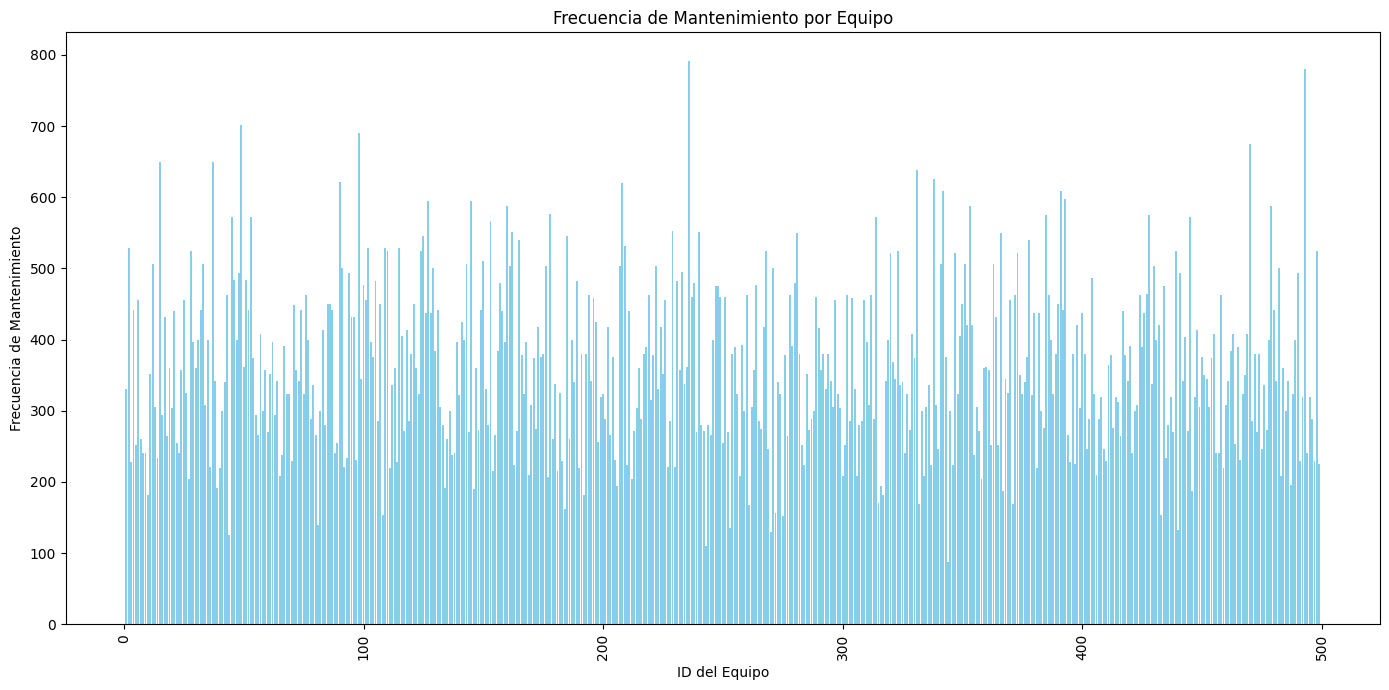

In [339]:
import matplotlib.pyplot as plt

# Calcular la frecuencia de mantenimiento total (correctivo + preventivo) por equipo
tabla_unida['Frecuencia_Total'] = tabla_unida  ['Frecuencia_Correctivo'] + tabla_unida   ['Frecuencia_Preventivo']

# Crear una gráfica de barras para mostrar la frecuencia de mantenimiento por equipo
plt.figure(figsize=(14, 7))
plt.bar(tabla_unida['ID_Equipo'], tabla_unida  ['Frecuencia_Total'], color='skyblue')
plt.xlabel('ID del Equipo')
plt.ylabel('Frecuencia de Mantenimiento')
plt.title('Frecuencia de Mantenimiento por Equipo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [340]:
# Extraer el DataFrame limpio a un archivo CSV

tabla_unida_df = pd.DataFrame(tabla_unida)

tabla_unida_df.to_csv(ruta + 'etapa3/output/Informacion_relevante_equipos.csv', index=False)


print("El DataFrame tabla_unida_df se ha extraído a *.csv")

El DataFrame tabla_unida_df se ha extraído a *.csv


#### Vida útil estimada: Estimación de la vida útil de los equipos basada en las horas operativas.

- Utilizando la columna Vida_Util_Estimada generada anteriormente, se calcula la vida util restante.

In [341]:
# Calcular la vida útil restante basada en las horas operativas actuales y en la vida util estimada
tabla_unida['Vida_Util_Restante'] = tabla_unida['Vida_Util_Estimada'] - condiciones_df_clean['Horas_Operativas']

# Mostrar el DataFrame con la vida útil restante calculada
tabla_unida

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Frecuencia_Correctivo,Frecuencia_Preventivo,Vida_Util_Estimada,Frecuencia_Total,Vida_Util_Restante
0,1,Compresor,Siemens,Z300,120,210,97100.0,330,25251.0
1,2,Transformador,Siemens,Y200,308,220,99650.0,528,49980.0
2,3,Compresor,ABB,Z300,133,95,99319.0,228,66213.0
3,4,Compresor,GE,X100,168,273,98682.0,441,66938.0
4,5,Motor,Siemens,Y200,112,140,85905.0,252,7801.0
...,...,...,...,...,...,...,...,...,...
494,495,Motor,Schneider,Z300,128,192,86053.0,320,55985.0
495,496,Transformador,Schneider,Z300,144,144,93153.0,288,39835.0
496,497,Compresor,GE,M400,130,100,99846.0,230,94757.0
497,498,Generador,Siemens,X100,250,275,96724.0,525,49476.0


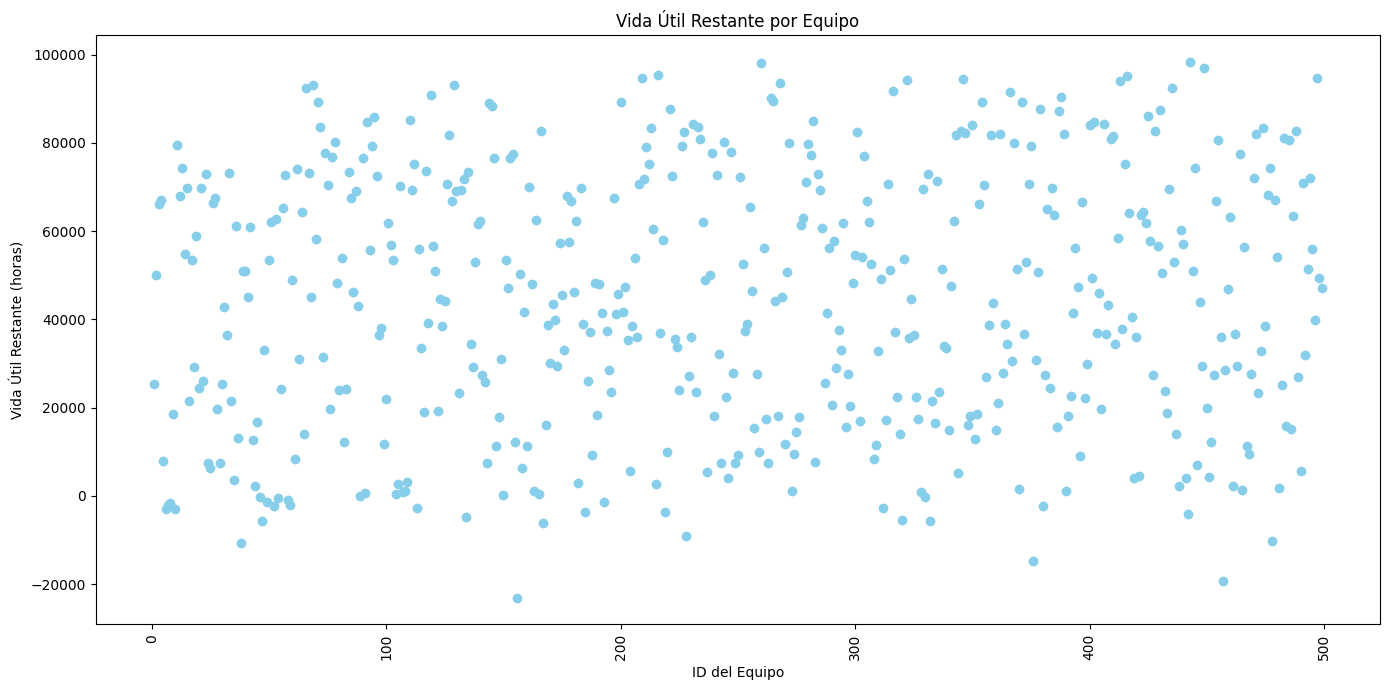

In [342]:

# Crear un gráfico de dispersión para mostrar la vida útil restante por equipo
plt.figure(figsize=(14, 7))
plt.scatter(tabla_unida['ID_Equipo'], tabla_unida['Vida_Util_Restante'], color='skyblue')
plt.xlabel('ID del Equipo')
plt.ylabel('Vida Útil Restante (horas)')
plt.title('Vida Útil Restante por Equipo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Tiempo hasta fallo: ¿Cuánto tiempo de operación transcurre hasta que un equipo requiere mantenimiento?

- Se genera una tabla nueva donde se predice Tiempo hasta fallo: ¿Cuánto tiempo de operación transcurre hasta que un equipo requiere mantenimiento
- Se extrae también a un csv

In [343]:
# Crear una copia del DataFrame original para no modificarlo
ordenes_df_temp = ordenes_df_cleaned.copy()

# Convertir la columna Fecha a datetime
ordenes_df_temp['Fecha_Ordenes'] = pd.to_datetime(ordenes_df_temp['Fecha_Ordenes'], errors='coerce')

# Ordenar el DataFrame por ID_Equipo y Fecha_Ordenes
ordenes_df_temp = ordenes_df_temp.sort_values(by=['ID_Equipo', 'Fecha_Ordenes'])

# Calcular la diferencia de tiempo entre cada Fecha_Ordenes para cada ID_Equipo
ordenes_df_temp['Tiempo_Entre_Ordenes'] = ordenes_df_temp.groupby('ID_Equipo')['Fecha_Ordenes'].diff()

# Calcular la media de Tiempo_Entre_Ordenes para cada ID_Equipo
media_tiempo_entre_ordenes = ordenes_df_temp.groupby('ID_Equipo')['Tiempo_Entre_Ordenes'].mean().reset_index()

# Renombrar la columna para mayor claridad
media_tiempo_entre_ordenes.columns = ['ID_Equipo', 'Tiempo_hasta_fallo']

# Mostrar el resultado
media_tiempo_entre_ordenes


,ID_Equipo,Tiempo_hasta_fallo
0,1,17 days 23:51:25.714285714
1,2,17 days 22:31:18.260869565
2,3,31 days 07:05:27.272727272
3,4,18 days 23:09:00
4,5,23 days 00:28:14.117647058
...,...,...
494,495,20 days 04:06:18.947368421
495,496,22 days 00:32:00
496,497,18 days 11:08:10.909090909
497,498,20 days 07:57:00


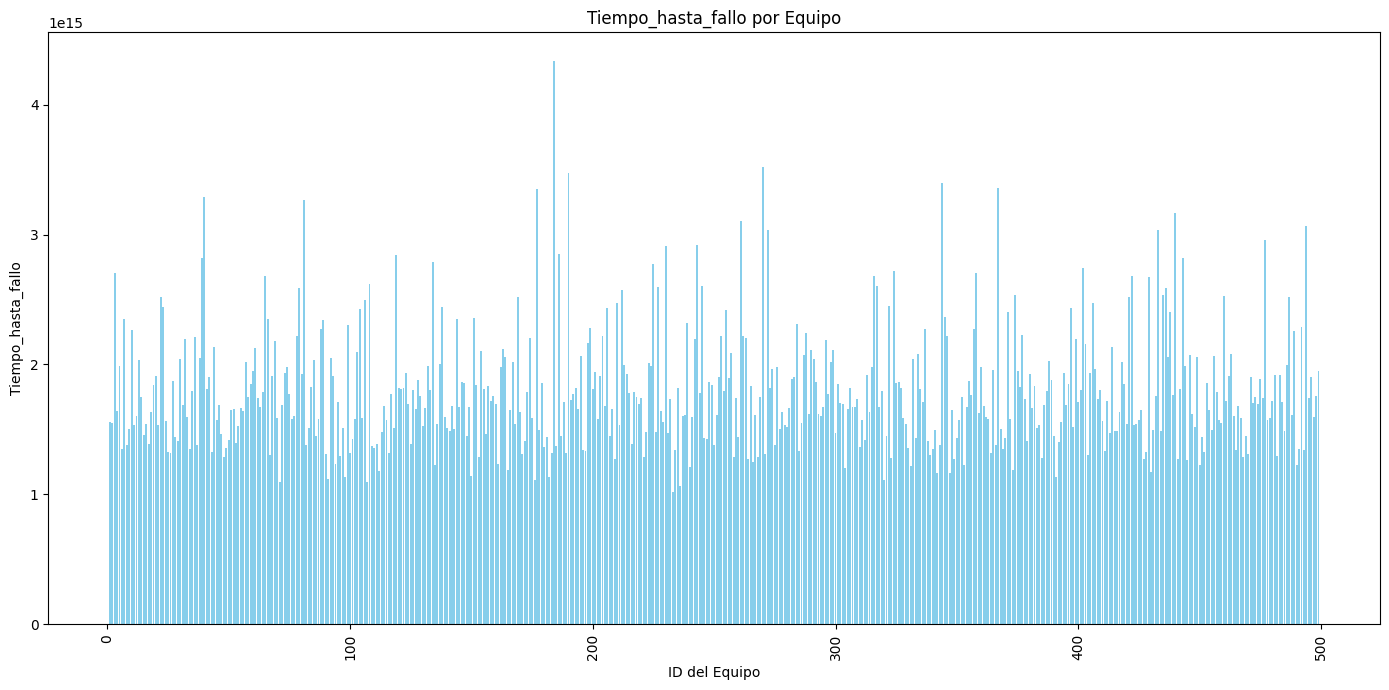

In [344]:
import matplotlib.pyplot as plt

# Crear una gráfica de barras para mostrar el Tiempo_hasta_fallo por equipo
plt.figure(figsize=(14, 7))
plt.bar(media_tiempo_entre_ordenes['ID_Equipo'], media_tiempo_entre_ordenes['Tiempo_hasta_fallo'], color='skyblue')
plt.xlabel('ID del Equipo')
plt.ylabel('Tiempo_hasta_fallo')
plt.title('Tiempo_hasta_fallo por Equipo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [345]:
# Extraer el DataFrame Tiempo_hasta_fallo a un archivo CSV

media_tiempo_entre_ordenes.to_csv(ruta + 'etapa3/output/Tiempo_hasta_fallo.csv', index=False)


print("El DataFrame se ha extraído a *.csv")

El DataFrame se ha extraído a *.csv


#### Relación entre condiciones operativas y fallos: ¿Cómo impactan la vibración o temperatura en la probabilidad de un fallo?

- Se llega a la conclusión de que la temperatura y sobre todo las vibraciones tienen tendencia a aumentar hasta que ocurre el fallo y hay una acuación a través de una orden. Después sus valores descienden y y vuelven a valores normales.

In [346]:
# Generar una nueva tabla con las columnas ID_Equipo, Fecha_Ordenes, Tipo_Mantenimiento, Fecha_Registros,Temperatura_C y Vibracion_mm_s
condiciones_operativas = mantenimiento_df[['ID_Equipo', 'Fecha_Ordenes', 'Tipo_Mantenimiento', 'Fecha_Registros', 'Temperatura_C', 'Vibracion_mm_s']]

# Mostrar la nueva tabla
condiciones_operativas

,ID_Equipo,Fecha_Ordenes,Tipo_Mantenimiento,Fecha_Registros,Temperatura_C,Vibracion_mm_s
0,1,2020-02-03 06:00:00,Preventivo,2020-01-02 03:00:00,93.80,0.70
1,1,2020-02-03 06:00:00,Preventivo,2020-01-21 01:00:00,102.99,2.31
2,1,2020-02-03 06:00:00,Preventivo,2020-03-02 14:00:00,145.97,1.57
3,1,2020-02-03 06:00:00,Preventivo,2020-03-16 04:00:00,147.18,2.49
4,1,2020-02-03 06:00:00,Preventivo,2020-04-17 22:00:00,58.93,3.54
...,...,...,...,...,...,...
180263,499,2020-12-24 05:00:00,Preventivo,2020-11-06 04:00:00,65.47,0.61
180264,499,2020-12-24 05:00:00,Preventivo,2020-11-13 04:00:00,88.84,0.88
180265,499,2020-12-24 05:00:00,Preventivo,2020-11-13 22:00:00,146.08,0.70
180266,499,2020-12-24 05:00:00,Preventivo,2020-11-25 05:00:00,100.30,4.03


In [347]:
# Filtrar las filas donde Tipo_Mantenimiento es "Correctivo"
condiciones_operativas_correctivo = condiciones_operativas[condiciones_operativas['Tipo_Mantenimiento'] == 'Correctivo']

# Mostrar la tabla filtrada
condiciones_operativas_correctivo

,ID_Equipo,Fecha_Ordenes,Tipo_Mantenimiento,Fecha_Registros,Temperatura_C,Vibracion_mm_s
15,1,2020-02-04 20:00:00,Correctivo,2020-01-02 03:00:00,93.80,0.70
16,1,2020-02-04 20:00:00,Correctivo,2020-01-21 01:00:00,102.99,2.31
17,1,2020-02-04 20:00:00,Correctivo,2020-03-02 14:00:00,145.97,1.57
18,1,2020-02-04 20:00:00,Correctivo,2020-03-16 04:00:00,147.18,2.49
19,1,2020-02-04 20:00:00,Correctivo,2020-04-17 22:00:00,58.93,3.54
...,...,...,...,...,...,...
180232,499,2020-09-02 13:00:00,Correctivo,2020-10-26 03:00:00,62.18,2.60
180233,499,2020-09-02 13:00:00,Correctivo,2020-11-06 04:00:00,65.47,0.61
180234,499,2020-09-02 13:00:00,Correctivo,2020-11-13 04:00:00,88.84,0.88
180235,499,2020-09-02 13:00:00,Correctivo,2020-11-13 22:00:00,146.08,0.70


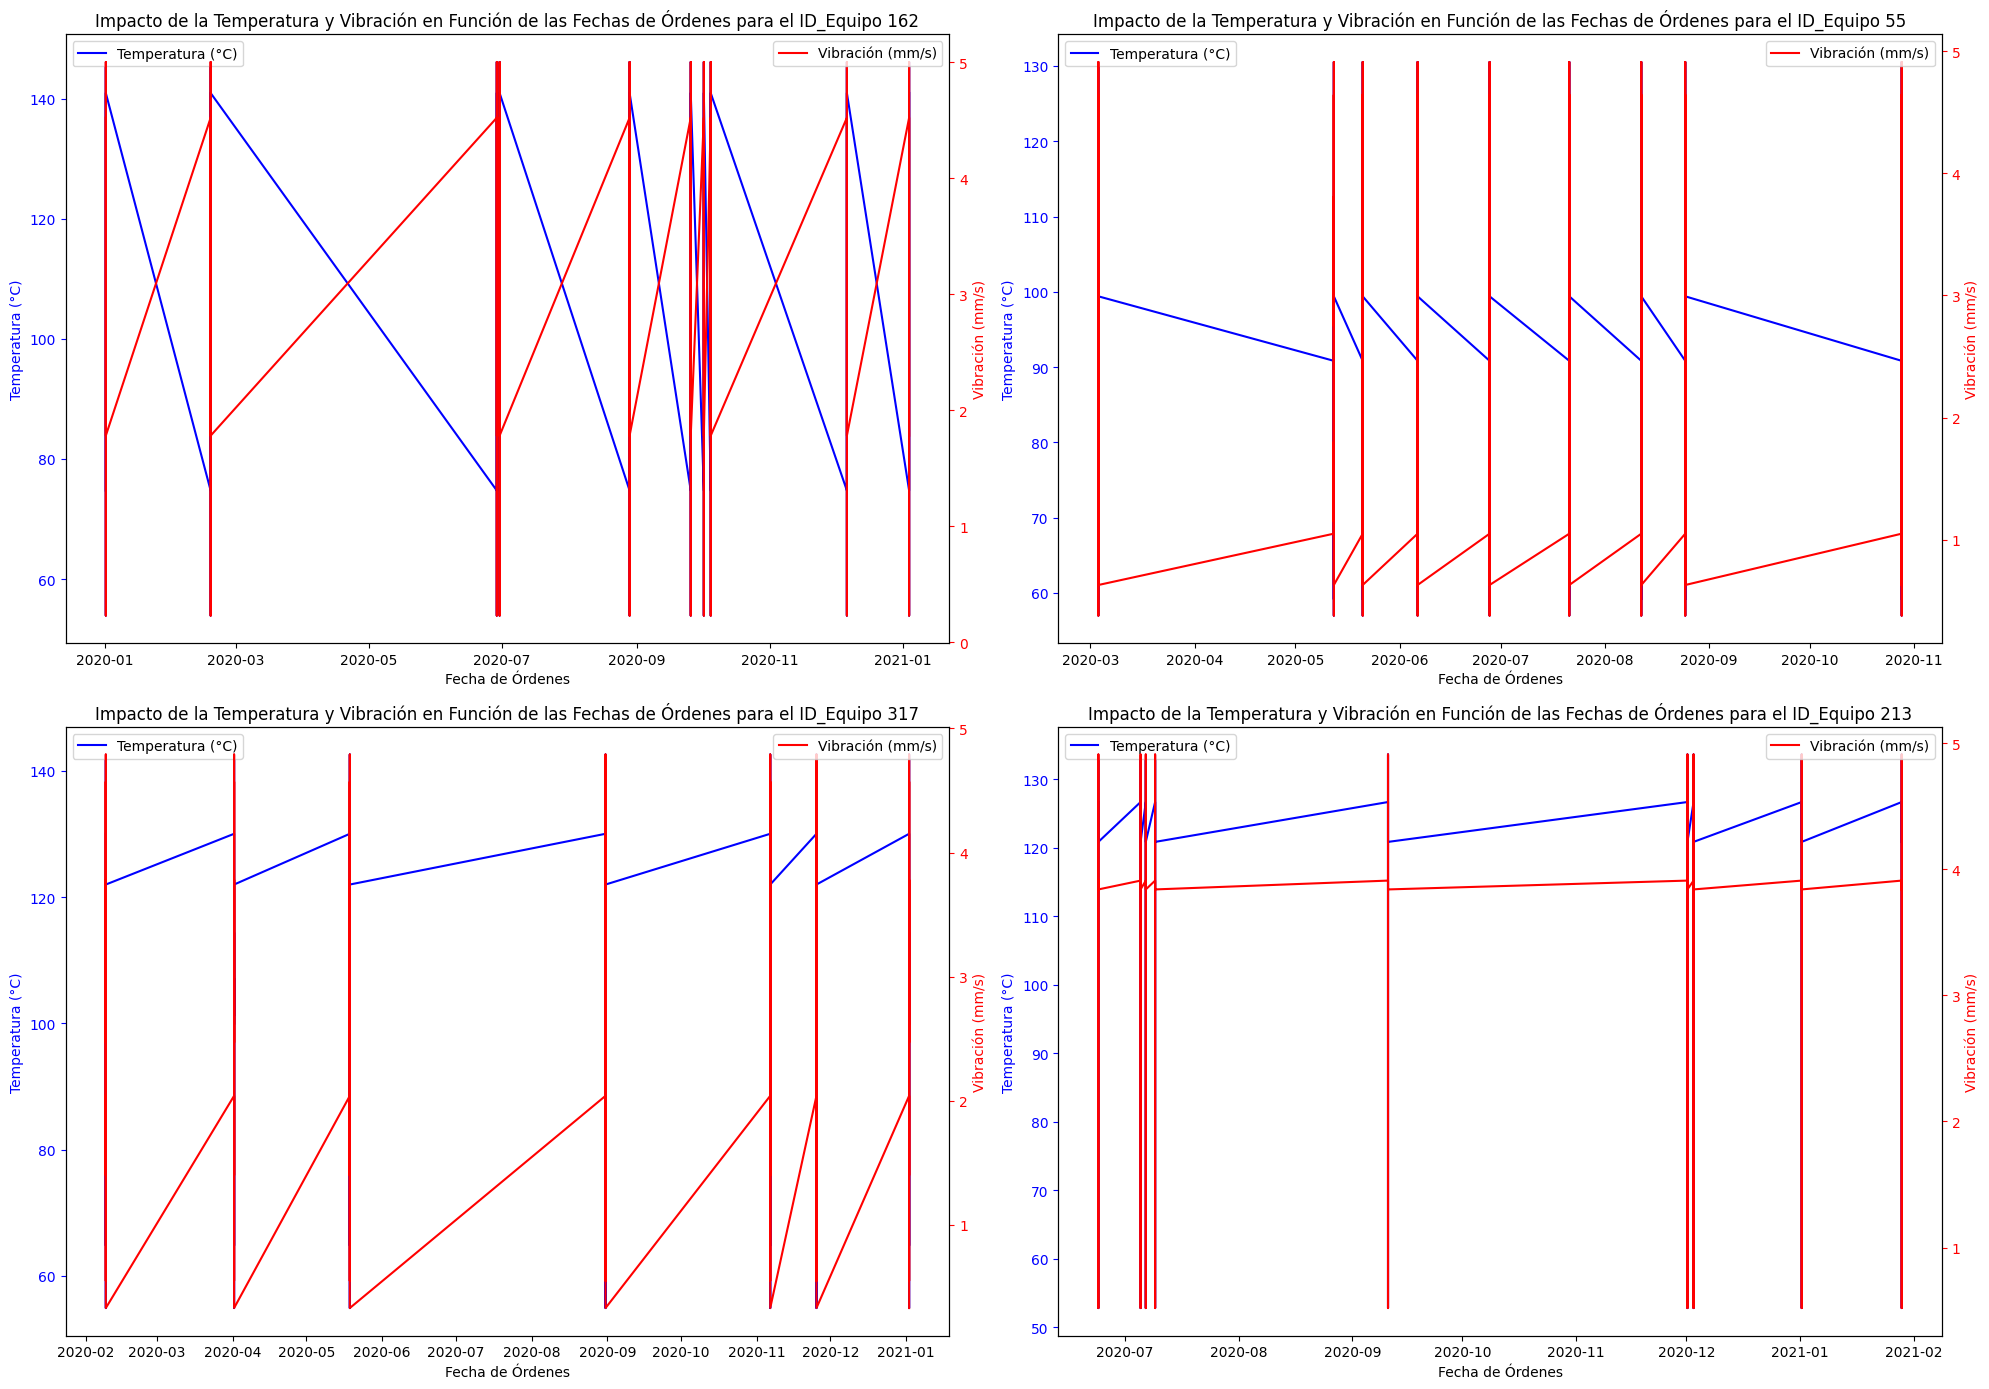

In [348]:
# Se genera una gráfica para varios equipos a la vez

import matplotlib.pyplot as plt
import random

# Generar 4 ID_Equipo aleatorios únicos entre 1 y 499
random_ids = random.sample(range(1, 500), 4)

# Crear una figura con 4 subgráficas
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Iterar sobre los ID_Equipo aleatorios y los ejes de las subgráficas
for i, (ax1, equipo_id) in enumerate(zip(axs.flatten(), random_ids)):
    # Filtrar los datos para el ID_Equipo actual
    condiciones_operativas_correctivo_id = condiciones_operativas_correctivo[condiciones_operativas_correctivo['ID_Equipo'] == equipo_id]
    
    # Convertir la columna Fecha_Ordenes a datetime si no lo está
    condiciones_operativas_correctivo_id['Fecha_Ordenes'] = pd.to_datetime(condiciones_operativas_correctivo_id['Fecha_Ordenes'])
    
    # Graficar la temperatura en función de las fechas de órdenes
    ax1.plot(condiciones_operativas_correctivo_id['Fecha_Ordenes'], condiciones_operativas_correctivo_id['Temperatura_C'], 'b-', label='Temperatura (°C)')
    ax1.set_xlabel('Fecha de Órdenes')
    ax1.set_ylabel('Temperatura (°C)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper left')
    
    # Crear un segundo eje para la vibración
    ax2 = ax1.twinx()
    ax2.plot(condiciones_operativas_correctivo_id['Fecha_Ordenes'], condiciones_operativas_correctivo_id['Vibracion_mm_s'], 'r-', label='Vibración (mm/s)')
    ax2.set_ylabel('Vibración (mm/s)', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')
    
    # Establecer el título para cada subgráfica
    ax1.set_title(f'Impacto de la Temperatura y Vibración en Función de las Fechas de Órdenes para el ID_Equipo {equipo_id}')

# Ajustar el diseño
fig.tight_layout()

# Mostrar la gráfica
plt.show()

#### Relación entre las condiciones operativas (temperatura, vibración) y las horas de operación.

- Se observa una ligera tendencia en aumento en función de las horas de operación
- A lo largo del tiempo, se observan distintas bajadas de valores debidos a intervenciones de mantenimiento.

In [349]:
# Generaro una nueva tabla con las columnas ID_Equipo, Temperatura_C, Vibracion_mm_s y Horas_Operativas
tabla_condiciones = mantenimiento_df[['ID_Equipo', 'Temperatura_C', 'Vibracion_mm_s', 'Horas_Operativas']]

# Ordeno la tabla por ID_Equipo y luego por Horas_Operativas
tabla_condiciones_ordenada = tabla_condiciones.sort_values(by=['ID_Equipo', 'Horas_Operativas'])

# Muestro la tabla ordenada
tabla_condiciones_ordenada

,ID_Equipo,Temperatura_C,Vibracion_mm_s,Horas_Operativas
3,1,147.18,2.49,6872.0
18,1,147.18,2.49,6872.0
33,1,147.18,2.49,6872.0
48,1,147.18,2.49,6872.0
63,1,147.18,2.49,6872.0
...,...,...,...,...
180208,499,127.13,1.58,85233.0
180223,499,127.13,1.58,85233.0
180238,499,127.13,1.58,85233.0
180253,499,127.13,1.58,85233.0


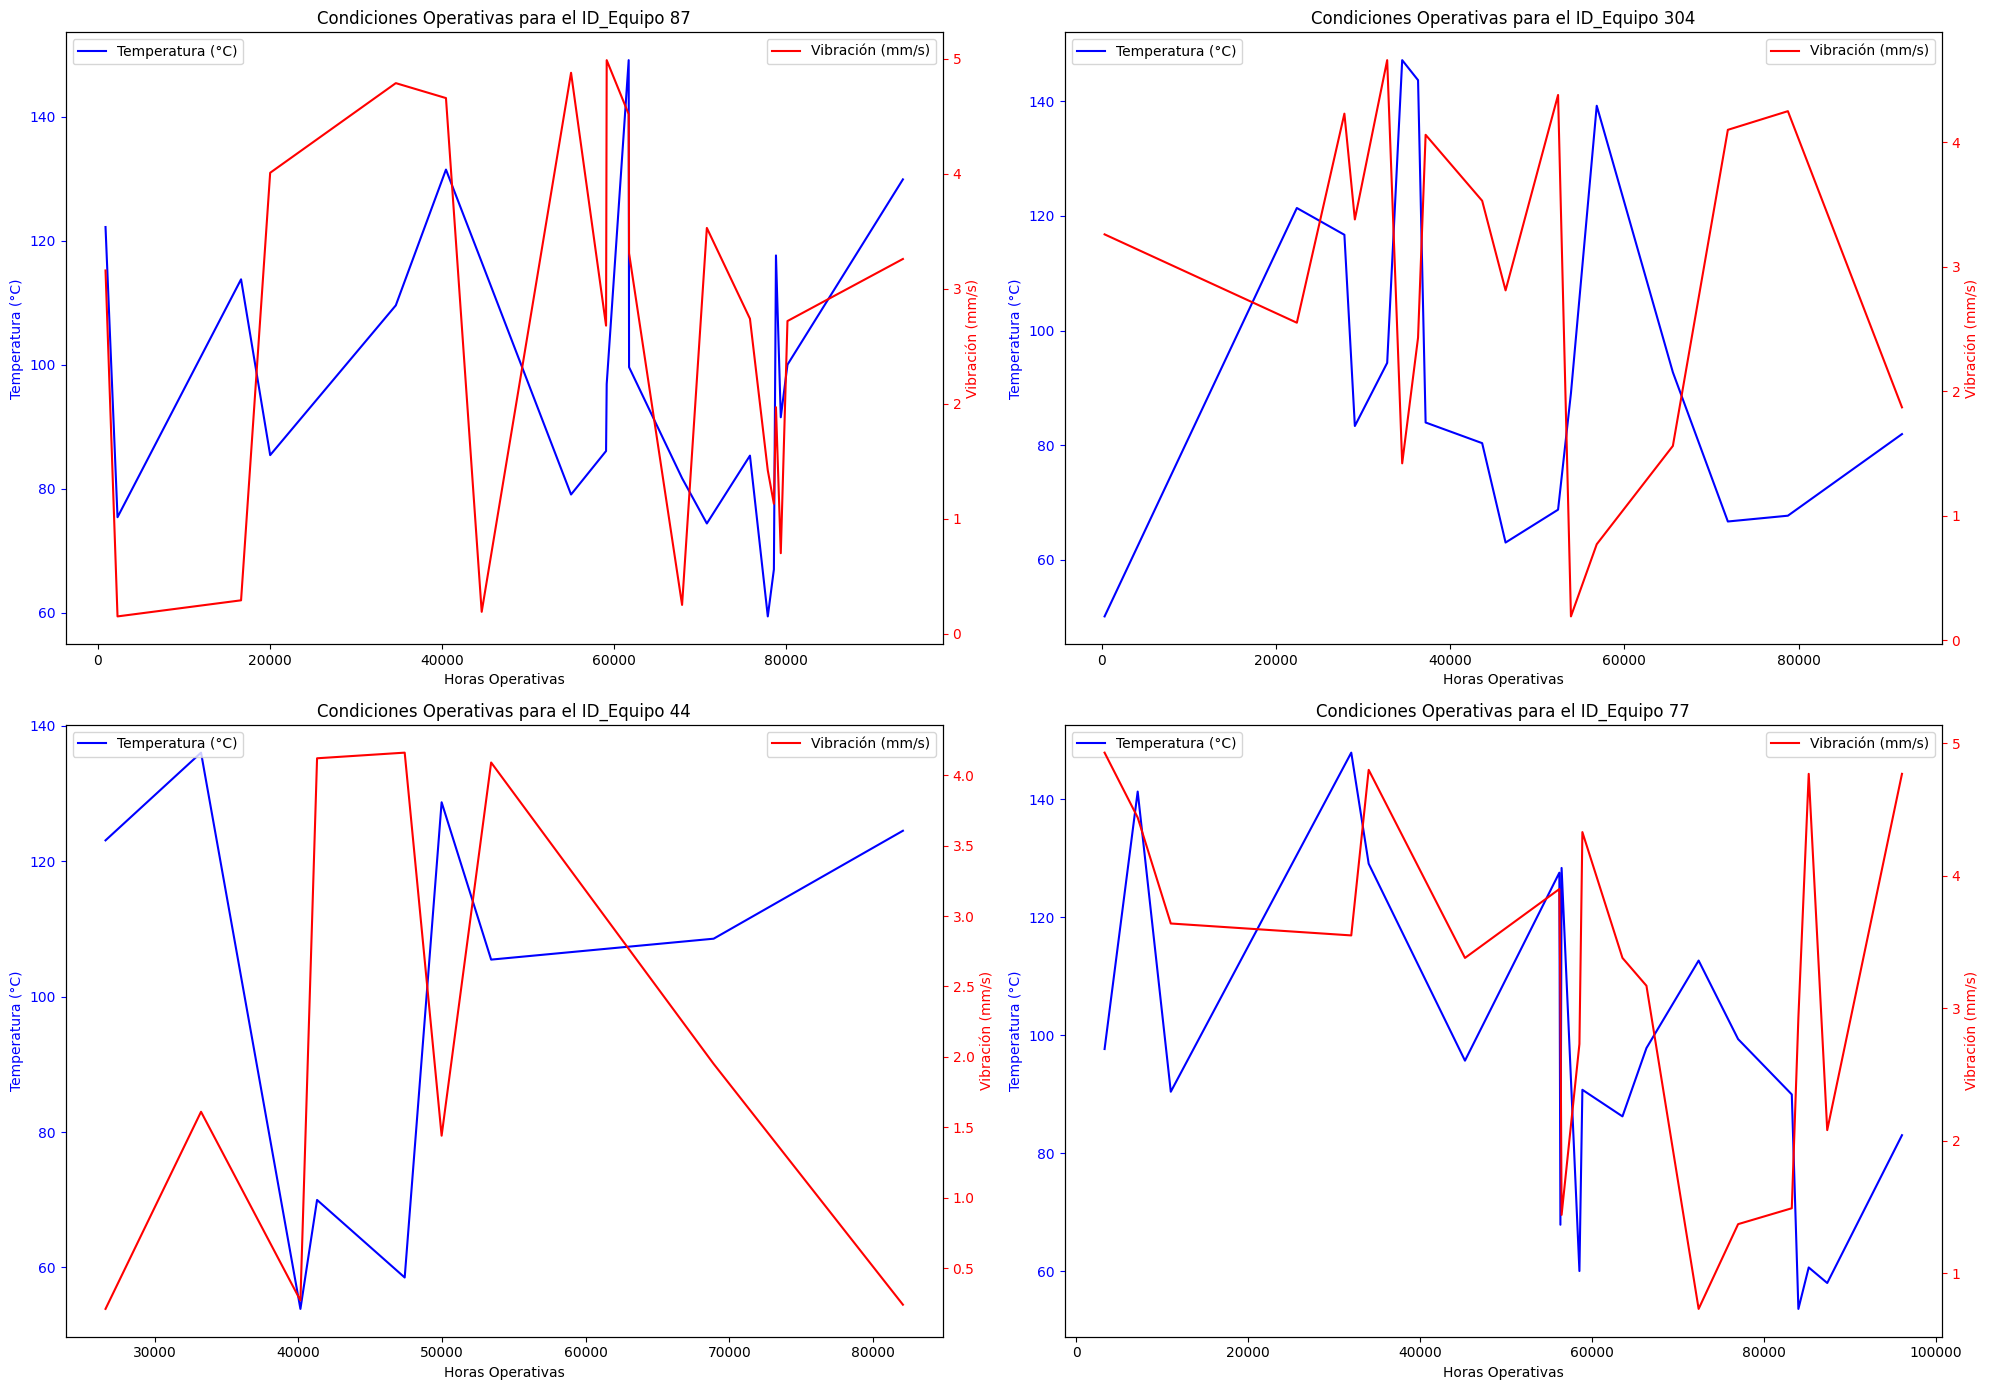

In [350]:
import matplotlib.pyplot as plt

# Genero 4 ID_Equipo aleatorios únicos entre los disponibles en la tabla
random_ids = random.sample(tabla_condiciones_ordenada['ID_Equipo'].unique().tolist(), 4)

# Cro una figura con 4 subgráficas
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Itero sobre los ID_Equipo aleatorios y los ejes de las subgráficas
for i, (ax, equipo_id) in enumerate(zip(axs.flatten(), random_ids)):
    # Filtrar los datos para el ID_Equipo actual
    tabla_equipo = tabla_condiciones_ordenada[tabla_condiciones_ordenada['ID_Equipo'] == equipo_id]
    
    # Graficar la temperatura y la vibración en función de las horas operativas
    ax.plot(tabla_equipo['Horas_Operativas'], tabla_equipo['Temperatura_C'], 'b-', label='Temperatura (°C)')
    ax.set_xlabel('Horas Operativas')
    ax.set_ylabel('Temperatura (°C)', color='b')
    ax.tick_params('y', colors='b')
    ax.legend(loc='upper left')
    
    # Crear un segundo eje para la vibración
    ax2 = ax.twinx()
    ax2.plot(tabla_equipo['Horas_Operativas'], tabla_equipo['Vibracion_mm_s'], 'r-', label='Vibración (mm/s)')
    ax2.set_ylabel('Vibración (mm/s)', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')
    
    # Establecer el título para cada subgráfica
    ax.set_title(f'Condiciones Operativas para el ID_Equipo {equipo_id}')

# Ajustar el diseño
fig.tight_layout()

# Mostrar la gráfica
plt.show()

### Gráficas de barras para mostrar la distribución del costo de mantenimiento por tipo de equipo

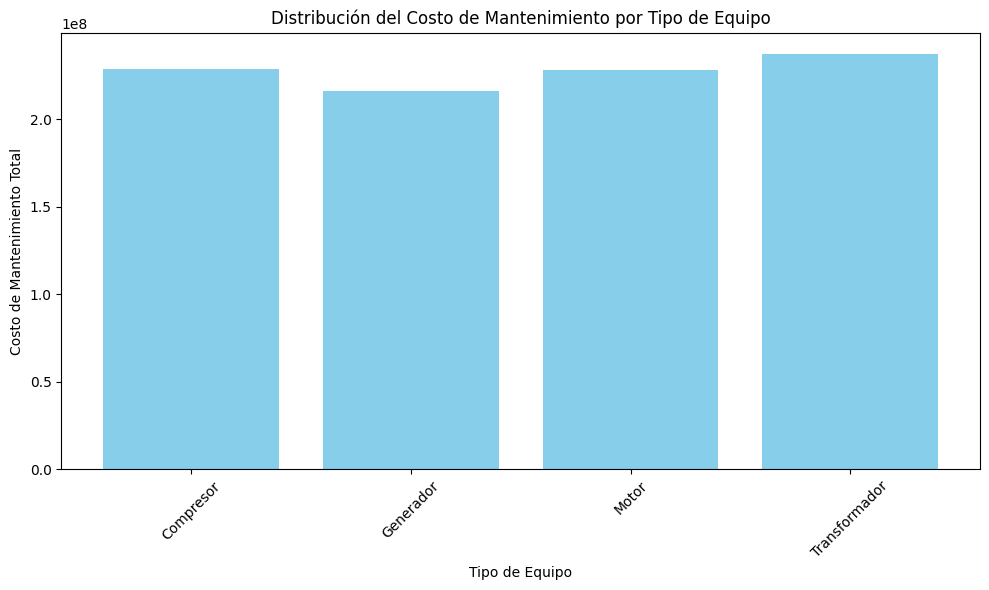

In [351]:
import matplotlib.pyplot as plt

# Agrupar los datos por Tipo_Equipo y calcular el costo de mantenimiento total para cada tipo
costo_mantenimiento_por_tipo = mantenimiento_df.groupby('Tipo_Equipo')['Costo_Mantenimiento'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(costo_mantenimiento_por_tipo['Tipo_Equipo'], costo_mantenimiento_por_tipo['Costo_Mantenimiento'], color='skyblue')
plt.xlabel('Tipo de Equipo')
plt.ylabel('Costo de Mantenimiento Total')
plt.title('Distribución del Costo de Mantenimiento por Tipo de Equipo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Diagramas de dispersión para visualizar la relación entre las condiciones operativas (por ejemplo, temperatura y vibración) y las horas de operación o fallos

In [ ]:
# Se genera una gráfica para varios equipos a la vez

import matplotlib.pyplot as plt
import random

# Generar 4 ID_Equipo aleatorios únicos entre 1 y 499
random_ids = random.sample(range(1, 500), 4)

# Crear una figura con 4 subgráficas
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Iterar sobre los ID_Equipo aleatorios y los ejes de las subgráficas
for i, (ax1, equipo_id) in enumerate(zip(axs.flatten(), random_ids)):
    # Filtrar los datos para el ID_Equipo actual
    condiciones_operativas_correctivo_id = condiciones_operativas_correctivo[condiciones_operativas_correctivo['ID_Equipo'] == equipo_id]
    
    # Convertir la columna Fecha_Ordenes a datetime si no lo está
    condiciones_operativas_correctivo_id['Fecha_Ordenes'] = pd.to_datetime(condiciones_operativas_correctivo_id['Fecha_Ordenes'])
    
    # Graficar la temperatura en función de las fechas de órdenes
    ax1.plot(condiciones_operativas_correctivo_id['Fecha_Ordenes'], condiciones_operativas_correctivo_id['Temperatura_C'], 'b-', label='Temperatura (°C)')
    ax1.set_xlabel('Fecha de Órdenes')
    ax1.set_ylabel('Temperatura (°C)', color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper left')
    
    # Crear un segundo eje para la vibración
    ax2 = ax1.twinx()
    ax2.plot(condiciones_operativas_correctivo_id['Fecha_Ordenes'], condiciones_operativas_correctivo_id['Vibracion_mm_s'], 'r-', label='Vibración (mm/s)')
    ax2.set_ylabel('Vibración (mm/s)', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')
    
    # Establecer el título para cada subgráfica
    ax1.set_title(f'Impacto de la Temperatura y Vibración en Función de las Fechas de Órdenes para el ID_Equipo {equipo_id}')

# Ajustar el diseño
fig.tight_layout()

# Mostrar la gráfica
plt.show()

### Crear un diagrama de caja para identificar los outliers en las horas operativas o costos de mantenimiento

In [ ]:
import matplotlib.pyplot as plt

# Crear un diagrama de caja para las horas operativas
plt.figure(figsize=(8, 4))
plt.boxplot(mantenimiento_df['Horas_Operativas'], vert=True)
plt.xlabel('Horas Operativas')
plt.title('Diagrama de Caja para Horas Operativas')
plt.show()

# Crear un diagrama de caja para los costos de mantenimiento
plt.figure(figsize=(8, 4))
plt.boxplot(mantenimiento_df['Costo_Mantenimiento'], vert=True)
plt.xlabel('Costo de Mantenimiento')
plt.title('Diagrama de Caja para Costo de Mantenimiento')
plt.show()

### Generar una visualización de la frecuencia de mantenimiento por tipo de equipo y la relación con el tipo de mantenimiento (correctivo/preventivo)

In [ ]:
import matplotlib.pyplot as plt

# Calcular la frecuencia de mantenimiento por tipo de equipo y tipo de mantenimiento
frecuencia_mantenimiento_tipo = mantenimiento_df.groupby(['Tipo_Equipo', 'Tipo_Mantenimiento']).size().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
frecuencia_mantenimiento_tipo.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.xlabel('Tipo de Equipo')
plt.ylabel('Frecuencia de Mantenimiento')
plt.title('Frecuencia de Mantenimiento por Tipo de Equipo y Tipo de Mantenimiento')
plt.legend(title='Tipo de Mantenimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analisis y exportación Profiling

### ANALISIS PROFILING ARCHIVO CONJUNTO

In [ ]:
mantenimiento_df = pd.read_csv(ruta + 'Etapa3/output/Mantenimiento.csv')

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(mantenimiento_df, title="Mantenimiento Profiling Report")

In [ ]:
profile.to_notebook_iframe()

In [ ]:
profile.to_file(ruta + 'Etapa3/output/Mantenimiento.html')

# Selección de candidatos
##### (la mayoria de proceso de limpieza se ha realizado en los df individuales)

### Definición del Target

In [344]:
### Carga archivo

mantenimiento = pd.read_csv(ruta + 'etapa3/output/Mantenimiento.csv')
mantenimiento_df = pd.DataFrame(mantenimiento)
mantenimiento_df

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,ID_Orden,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Duracion_Horas,Ubicacion,ID_Registro,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas
0,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,28.0,2020-01-02 03:00:00,93.80,0.70,80054.0
1,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,482.0,2020-01-21 01:00:00,102.99,2.31,74797.0
2,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1479.0,2020-03-02 14:00:00,145.97,1.57,95240.0
3,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,1805.0,2020-03-16 04:00:00,147.18,2.49,6872.0
4,1,Compresor,Siemens,Z300,3429.0,7725,799.0,2020-02-03 06:00:00,Preventivo,404.72,37.0,Planta Oeste,2591.0,2020-04-17 22:00:00,58.93,3.54,28186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180263,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7445.0,2020-11-06 04:00:00,65.47,0.61,11466.0
180264,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7613.0,2020-11-13 04:00:00,88.84,0.88,58159.0
180265,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7631.0,2020-11-13 22:00:00,146.08,0.70,46817.0
180266,499,Motor,Siemens,Y200,3155.0,932,8598.0,2020-12-24 05:00:00,Preventivo,4446.64,18.0,Planta Sur,7902.0,2020-11-25 05:00:00,100.30,4.03,57567.0


In [345]:
target_column = "Tipo_Mantenimiento"

mantenimiento_df.shape

(180268, 17)

### Explorar

In [346]:
mantenimiento_df.shape

(180268, 17)

In [347]:
mantenimiento_df.describe()

,ID_Equipo,Potencia_kW,Horas_Recomendadas_Revision,ID_Orden,Costo_Mantenimiento,Duracion_Horas,ID_Registro,Temperatura_C,Vibracion_mm_s,Horas_Operativas
count,180268.000000,180268.000000,180268.000000,180267.000000,180267.000000,180267.000000,180267.000000,180267.000000,180267.000000,180267.000000
mean,247.985239,2470.801049,5334.057625,4991.817820,5047.404081,23.925133,4504.505933,99.593918,2.568582,50069.115025
std,144.017229,1442.058782,2729.142969,2890.227025,2858.600502,13.594612,2598.251376,28.882249,1.421553,28772.454679
min,1.000000,75.000000,509.000000,1.000000,101.510000,1.000000,1.000000,50.060000,0.100000,46.000000
25%,123.000000,1250.000000,3105.000000,2483.000000,2558.450000,12.000000,2253.000000,74.420000,1.320000,25091.000000
50%,245.000000,2390.000000,5328.000000,4986.000000,5054.724115,24.000000,4510.000000,99.490000,2.570000,50064.000000
75%,373.000000,3762.000000,7713.000000,7493.000000,7499.550000,36.000000,6758.000000,124.830000,3.830000,75201.000000
max,500.000000,4990.000000,9988.000000,10000.000000,9998.080000,47.000000,9000.000000,149.990000,5.000000,99991.000000


In [348]:
mantenimiento_df.describe(include=object)

,Tipo_Equipo,Fabricante,Modelo,Fecha_Ordenes,Tipo_Mantenimiento,Ubicacion,Fecha_Registros
count,180268,180268,180268,180267,180267,180267,180267
unique,4,4,4,10000,2,4,9000
top,Transformador,ABB,Y200,2021-01-16 05:00:00,Preventivo,Planta Este,2020-08-07 18:00:00
freq,46916,47250,51421,31,90837,46145,33


In [349]:
mantenimiento_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180268 entries, 0 to 180267
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_Equipo                    180268 non-null  int64  
 1   Tipo_Equipo                  180268 non-null  object 
 2   Fabricante                   180268 non-null  object 
 3   Modelo                       180268 non-null  object 
 4   Potencia_kW                  180268 non-null  float64
 5   Horas_Recomendadas_Revision  180268 non-null  int64  
 6   ID_Orden                     180267 non-null  float64
 7   Fecha_Ordenes                180267 non-null  object 
 8   Tipo_Mantenimiento           180267 non-null  object 
 9   Costo_Mantenimiento          180267 non-null  float64
 10  Duracion_Horas               180267 non-null  float64
 11  Ubicacion                    180267 non-null  object 
 12  ID_Registro                  180267 non-null  float64
 13 

### Limpiar

In [350]:
# Elimino columnas que no aportan nada y generan ruido en Historicos_Ordenes

mantenimiento_df = mantenimiento_df.drop(columns=['ID_Orden', 'Duracion_Horas', 'ID_Registro'])
mantenimiento_df.head()



,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Ubicacion,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas
0,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-01-02 03:00:00,93.80,0.70,80054.0
1,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-01-21 01:00:00,102.99,2.31,74797.0
2,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-03-02 14:00:00,145.97,1.57,95240.0
3,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-03-16 04:00:00,147.18,2.49,6872.0
4,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-04-17 22:00:00,58.93,3.54,28186.0


### Valores faltantes

In [351]:
# Datos vacios
print('Datos vacios en mantenimiento\n',mantenimiento_df.isna().sum())

Datos vacios en mantenimiento
 ID_Equipo                      0
Tipo_Equipo                    0
Fabricante                     0
Modelo                         0
Potencia_kW                    0
Horas_Recomendadas_Revision    0
Fecha_Ordenes                  1
Tipo_Mantenimiento             1
Costo_Mantenimiento            1
Ubicacion                      1
Fecha_Registros                1
Temperatura_C                  1
Vibracion_mm_s                 1
Horas_Operativas               1
dtype: int64


In [352]:
# Mostrar las filas que tienen valores vacíos
filas_vacias = mantenimiento_df[mantenimiento_df.isna().any(axis=1)]
filas_vacias

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Ubicacion,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas
180267,500,Transformador,GE,M400,2001.0,2031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [353]:
# Al no disponer de Historicos_Ordenes y Registros_Condiciones del ID_Equipo 500 se decide eliminar la fila

# Eliminar la fila con valores vacíos
mantenimiento_df = mantenimiento_df.dropna()

# Datos vacios
print('Datos vacios en mantenimiento\n',mantenimiento_df.isna().sum())

Datos vacios en mantenimiento
 ID_Equipo                      0
Tipo_Equipo                    0
Fabricante                     0
Modelo                         0
Potencia_kW                    0
Horas_Recomendadas_Revision    0
Fecha_Ordenes                  0
Tipo_Mantenimiento             0
Costo_Mantenimiento            0
Ubicacion                      0
Fecha_Registros                0
Temperatura_C                  0
Vibracion_mm_s                 0
Horas_Operativas               0
dtype: int64


### Duplicados

In [354]:
# Mostrar todas las filas duplicadas
print('\nSumatorio duplicados en mantenimiento', mantenimiento_df.duplicated().sum())
mantenimiento_df[mantenimiento_df.duplicated(keep=False)]


Sumatorio duplicados en mantenimiento 0


,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Ubicacion,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas


### Outliers

In [355]:
# Extraer columnas numéricas y categóricas
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(mantenimiento_df)
categorical_columns = categorical_columns_selector(mantenimiento_df)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['ID_Equipo', 'Potencia_kW', 'Horas_Recomendadas_Revision', 'Costo_Mantenimiento', 'Temperatura_C', 'Vibracion_mm_s', 'Horas_Operativas']

Categorical columns
 ['Tipo_Equipo', 'Fabricante', 'Modelo', 'Fecha_Ordenes', 'Tipo_Mantenimiento', 'Ubicacion', 'Fecha_Registros']


In [356]:
# Outliers

# identificación
IQR = mantenimiento_df[numerical_columns].quantile(0.75) - mantenimiento_df[numerical_columns].quantile(0.25)
lower_bound = mantenimiento_df[numerical_columns].quantile(0.25) - (IQR * 3)
upper_bound = mantenimiento_df[numerical_columns].quantile(0.75) + (IQR * 3)

print(headr('lower_bound'),lower_bound)
print(headr('upper_bound'),upper_bound)

outliers = mantenimiento_df[numerical_columns][(mantenimiento_df[numerical_columns] < lower_bound) | (mantenimiento_df[numerical_columns] > upper_bound)]

print(headr("Outliers:"))
outliers.count()


lower_bound
 ID_Equipo                        -627.00
Potencia_kW                     -6286.00
Horas_Recomendadas_Revision    -10719.00
Costo_Mantenimiento            -12264.85
Temperatura_C                     -76.81
Vibracion_mm_s                     -6.21
Horas_Operativas              -125239.00
dtype: float64

upper_bound
 ID_Equipo                        1123.00
Potencia_kW                     11298.00
Horas_Recomendadas_Revision     21537.00
Costo_Mantenimiento             22322.85
Temperatura_C                     276.06
Vibracion_mm_s                     11.36
Horas_Operativas               225531.00
dtype: float64

Outliers:



ID_Equipo                      0
Potencia_kW                    0
Horas_Recomendadas_Revision    0
Costo_Mantenimiento            0
Temperatura_C                  0
Vibracion_mm_s                 0
Horas_Operativas               0
dtype: int64

### Añado caracteristicas desde archivos generados aneriormente

In [357]:
### Carga archivo

tiempo_fallo = pd.read_csv(ruta + 'etapa3/output/Tiempo_hasta_fallo.csv')
tiempo_fallo = pd.DataFrame(tiempo_fallo)

frecuencia = pd.read_csv(ruta + 'etapa3/output/Informacion_relevante_equipos.csv')
frecuencia = pd.DataFrame(frecuencia)

In [358]:
# Unir tiempo_fallo con mantenimiento_df usando la columna ID_Equipo como clave
#mantenimiento_df = pd.merge(mantenimiento_df, tiempo_fallo, on='ID_Equipo', how='left')

# Unir las columnas Frecuencia_Correctivo, Frecuencia_Preventivo y Vida_Util_Estimada del df frecuencia con mantenimiento_df
mantenimiento_df = pd.merge(
    mantenimiento_df,
    frecuencia[['ID_Equipo', 'Frecuencia_Correctivo', 'Frecuencia_Preventivo', 'Vida_Util_Estimada']],
    on='ID_Equipo',
    how='left'
)


# Mostrar las primeras filas del DataFrame resultante
mantenimiento_df.head()

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Ubicacion,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Frecuencia_Correctivo,Frecuencia_Preventivo,Vida_Util_Estimada
0,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-01-02 03:00:00,93.80,0.70,80054.0,120,210,97100.0
1,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-01-21 01:00:00,102.99,2.31,74797.0,120,210,97100.0
2,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-03-02 14:00:00,145.97,1.57,95240.0,120,210,97100.0
3,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-03-16 04:00:00,147.18,2.49,6872.0,120,210,97100.0
4,1,Compresor,Siemens,Z300,3429.0,7725,2020-02-03 06:00:00,Preventivo,404.72,Planta Oeste,2020-04-17 22:00:00,58.93,3.54,28186.0,120,210,97100.0


### Analizamos con datos limpios

In [359]:
# Transformamos columnas categoricas en valores numéricos

from sklearn.preprocessing import LabelEncoder

mantenimiento_dff = mantenimiento_df.copy()
mantenimiento_dff[categorical_columns] = mantenimiento_dff[categorical_columns].apply(LabelEncoder().fit_transform)   
mantenimiento_dff.head()

,ID_Equipo,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision,Fecha_Ordenes,Tipo_Mantenimiento,Costo_Mantenimiento,Ubicacion,Fecha_Registros,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Frecuencia_Correctivo,Frecuencia_Preventivo,Vida_Util_Estimada
0,1,0,3,3,3429.0,7725,798,1,404.72,2,27,93.80,0.70,80054.0,120,210,97100.0
1,1,0,3,3,3429.0,7725,798,1,404.72,2,481,102.99,2.31,74797.0,120,210,97100.0
2,1,0,3,3,3429.0,7725,798,1,404.72,2,1478,145.97,1.57,95240.0,120,210,97100.0
3,1,0,3,3,3429.0,7725,798,1,404.72,2,1804,147.18,2.49,6872.0,120,210,97100.0
4,1,0,3,3,3429.0,7725,798,1,404.72,2,2590,58.93,3.54,28186.0,120,210,97100.0


In [360]:
# Evaluamos la aportación de cada columna
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X= mantenimiento_dff.drop(target_column, axis=1)
y = mantenimiento_dff[target_column]

fvalue_selector = SelectKBest(f_classif, k=2)

X_kbest = fvalue_selector.fit(X,y)

feature_scores = pd.DataFrame({"Feature": X.columns,"Score": X_kbest.scores_}).sort_values(by="Score", ascending=False)

print(headr("Feature scores"))
round(feature_scores,2)


Feature scores



,Feature,Score
14,Frecuencia_Preventivo,3142.21
13,Frecuencia_Correctivo,2433.35
0,ID_Equipo,29.74
5,Horas_Recomendadas_Revision,28.47
2,Fabricante,22.67
3,Modelo,19.16
4,Potencia_kW,17.48
15,Vida_Util_Estimada,8.31
8,Ubicacion,4.53
12,Horas_Operativas,3.00



Graficando: ID_Equipo



KeyboardInterrupt: 

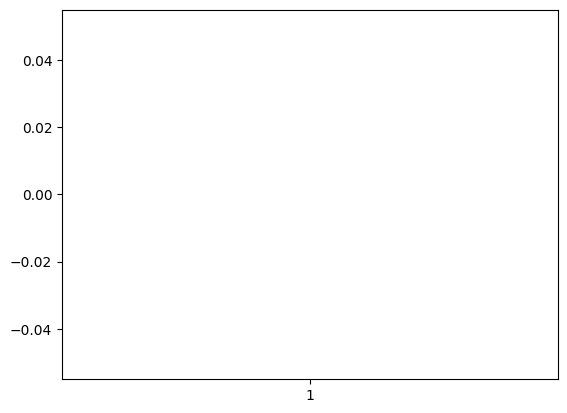

In [361]:
# Ver proporciones nuevamente

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


features = X.columns
num_features = len(features)

for i, feature in enumerate(features):
    print(headr(f"Graficando: {feature}"))
    sns.barplot(x=feature, y=target_column, data=mantenimiento_dff)
    plt.title(f"Tasa de {target_column} por {feature}")
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.show()

### Eliminar constantes

In [362]:
# Seleccionar características con varianza mayor a 5 o el valor que se desee, excluyendo target_column

from sklearn.feature_selection import VarianceThreshold


# Aplicar VarianceThreshold
sel = VarianceThreshold(threshold=5)
sel.fit(mantenimiento_dff)

# Obtener las columnas que no son constantes
no_constant_columns = sel.get_feature_names_out()
constant_columns = mantenimiento_dff.columns.drop(no_constant_columns)

print(headr("Columnas constantes:"), constant_columns)

# Actualizar mantenimiento_df excluyendo las columnas constantes
mantenimiento_const = mantenimiento_df.drop(columns=constant_columns)
print(headr("Columnas finales:"), mantenimiento_const.columns)


Columnas constantes:
 Index(['Tipo_Equipo', 'Fabricante', 'Modelo', 'Tipo_Mantenimiento',
       'Ubicacion', 'Vibracion_mm_s'],
      dtype='object')

Columnas finales:
 Index(['ID_Equipo', 'Potencia_kW', 'Horas_Recomendadas_Revision',
       'Fecha_Ordenes', 'Costo_Mantenimiento', 'Fecha_Registros',
       'Temperatura_C', 'Horas_Operativas', 'Frecuencia_Correctivo',
       'Frecuencia_Preventivo', 'Vida_Util_Estimada'],
      dtype='object')


### Separamos el target

In [363]:
# Separar características y target
X = mantenimiento_const
y = mantenimiento_dff[target_column] # Se coje el target transformado a numérico

### Preparar para entrenamiento

In [364]:
# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Candidatos

A partir del análisis previo:

1. `LogisticRegression`
2. `RandomForestClassifier` 
3. `GradientBoostingClassifier`
4. `KNeighborsClassifier`

### Piplines

In [365]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['ID_Equipo', 'Potencia_kW', 'Horas_Recomendadas_Revision', 'Costo_Mantenimiento', 'Temperatura_C', 'Horas_Operativas', 'Frecuencia_Correctivo', 'Frecuencia_Preventivo', 'Vida_Util_Estimada']

Categorical columns
 ['Fecha_Ordenes', 'Fecha_Registros']


In [366]:
preprocessor = ColumnTransformer(
    [
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(), categorical_columns)
    ])

pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())]),
    #"RandomForestClassifier": Pipeline([('preprocessor', preprocessor),('classifier', RandomForestClassifier())]),
    #"GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    "DecisionTreeClassifier": Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier())]),
    #"KNeighborsClassifier": Pipeline([('preprocessor', preprocessor),('classifier', KNeighborsClassifier())]),
}

### CV

In [367]:
def cv_train(name, pipeline, cv):
    print(headr(f"Entrenar {name}"))
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring="accuracy", return_estimator=True, return_train_score=True)
    trained_model = cv_results["estimator"][0]
    scores = pd.DataFrame(cv_results)

    print("test score (mean-std): {0:.2f} - {1:.2f}".format(scores["test_score"].mean(), scores["test_score"].std()))
    print("train score (mean-std): {0:.2f} - {1:.2f}".format(scores["train_score"].mean(), scores["train_score"].std()))
    print("params:", pipeline.named_steps.get("classifier").get_params())

    y_pred = trained_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return {"acc": round(scores["test_score"].mean(), 2), "f1": round(f1, 2),}

In [368]:
cvss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

results = {}

for name, pipeline in pipelines.items():
    results[name] = cv_train(name, pipeline, cvss)

print(headr("Resultados:"))
results_df=pd.DataFrame(results)
results_df


Entrenar LogisticRegression

test score (mean-std): 1.00 - 0.00
train score (mean-std): 1.00 - 0.00
params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Entrenar DecisionTreeClassifier

test score (mean-std): 1.00 - 0.00
train score (mean-std): 1.00 - 0.00
params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

Resultados:



,LogisticRegression,DecisionTreeClassifier
acc,1.0,1.0
f1,1.0,1.0


### Curva de aprendizaje

In [369]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve


In [383]:
# Curvas de aprendizaje

train_sizes = np.linspace(0.1, 1.0, num=10, endpoint=True)

def generate_learning_curves(name, pipeline, X, y, train_sizes):
    results = learning_curve(pipeline, X, y, train_sizes=train_sizes,
                             cv=cvss, scoring='accuracy')
    
    train_size, train_scores, test_scores = results[:3]

    # graficar la curva.
    plt.errorbar(train_size, train_scores.mean(axis=1),
                 yerr=train_scores.std(axis=1), label="Error de entrenamiento", color='blue', linestyle='--')
    plt.errorbar(train_size, test_scores.mean(axis=1),
                 yerr=test_scores.std(axis=1), label="Error de prueba", color='red', linestyle='-')
    plt.legend()

    plt.xscale("linear")
    plt.xlabel("Número de muestras en el conjunto de entrenamiento")
    plt.ylabel("Accuracy")
    plt.title("Curva de aprendizaje para {name}".format(name=name))
    plt.xlim(0, 160000)  # Ajusta según el rango esperado de los valores

    plt.show()

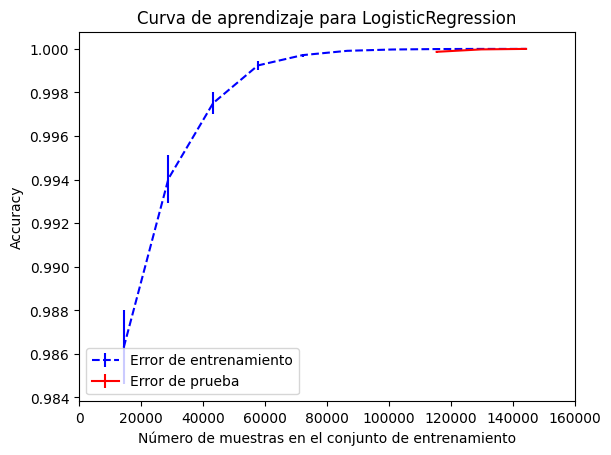

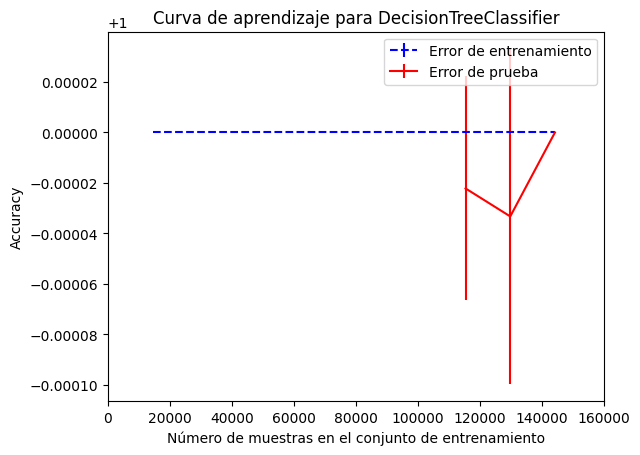

In [384]:
# Mostramos gráficas

for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes)

### Curva validación

In [275]:

# Curvas de validación

def generate_validation_curves(name, pipeline, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
        pipeline, X, y, param_name=param_name, param_range=param_range,
        cv=cvss, scoring="accuracy")

    # graficar la curva.
    plt.plot(param_range, train_scores.mean(
        axis=1), label="Error de entrenamiento")
    plt.plot(param_range, test_scores.mean(axis=1), label="Error de prueba")
    plt.legend()

    plt.xlabel("Valor del ({param_name})".format(
        param_name=param_name))
    plt.ylabel("Accuracy")
    plt.title("Curva de validación para {name}".format(name=name))

    plt.show()


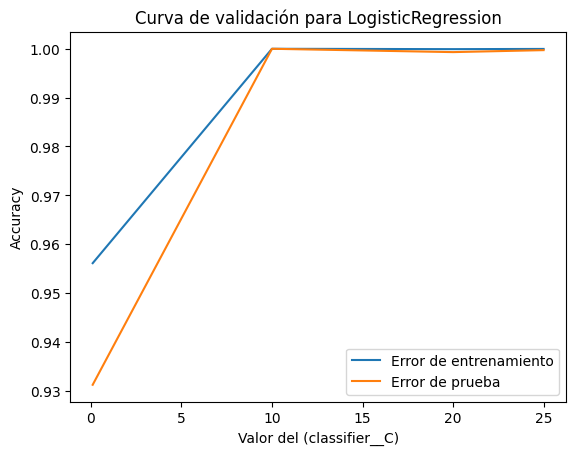

In [276]:
# Mostramos gráficas

pname = 'LogisticRegression'
Cs = [0.1,10,20,25]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__C', Cs)

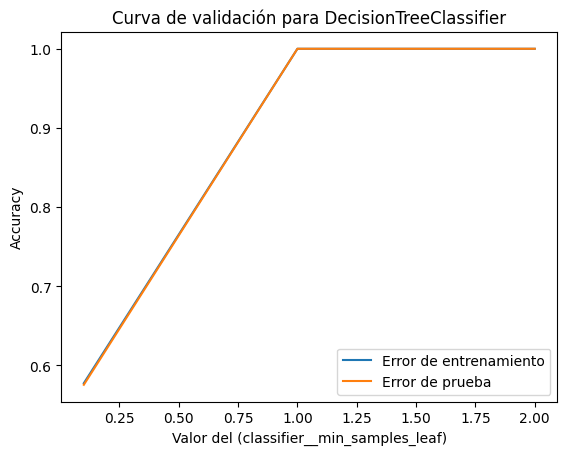

In [341]:
pname = 'DecisionTreeClassifier'
min_samples_leaf = [0.1, 1,2]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__min_samples_leaf', min_samples_leaf)

In [ ]:
pname = 'GradientBoostingClassifier'
max_depth = [10,20,30]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__max_depth', max_depth)

### Afinar hiperparámentros

In [279]:
from sklearn.model_selection import GridSearchCV

pname = 'LogisticRegression'

param_grid = {
    'classifier__C': [7.5, 9, 11.5],
    #'classifier__max_depth': [1, 2, 3, 4, 5],
    #'classifier__min_samples_split': [0.5, 1.5, 2, 3]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")


LogisticRegression

Mejores hiperparámetros: {'classifier__C': 7.5}
Mejor accuracy: 1.00


In [282]:
from sklearn.model_selection import GridSearchCV

pname = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [1, 2, 3],
    'classifier__min_samples_split': [0.5, 1.5, 2, 3]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")


DecisionTreeClassifier

Mejores hiperparámetros: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Mejor accuracy: 0.57


In [ ]:
from sklearn.model_selection import GridSearchCV

pname = 'GradientBoostingClassifier'

param_grid = {
    'classifier__n_estimators': [5,10,15],
    'classifier__max_depth': [10, 20, 30],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

### Afinar hiperparámetros

### re-entrenar + re-evaluar

In [336]:
preprocessor = ColumnTransformer(
    [
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(), categorical_columns)
    ])

pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression(C=7.5,penalty='l2',solver='lbfgs'))]),
    #"RandomForestClassifier": Pipeline([('preprocessor', preprocessor),('classifier', RandomForestClassifier())]),
    #"GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier)]),
    "DecisionTreeClassifier": Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(criterion='entropy',min_samples_leaf=1))]),
}

In [337]:
results_final = {}

for name, pipeline in pipelines.items():
    results_final[name] = cv_train(name, pipeline, cvss)


Entrenar LogisticRegression

test score (mean-std): 1.00 - 0.00
train score (mean-std): 1.00 - 0.00
params: {'C': 7.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Entrenar DecisionTreeClassifier

test score (mean-std): 1.00 - 0.00
train score (mean-std): 1.00 - 0.00
params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


# Almacenamiento

#### El CSV limpio se encuentra en la ruta ...../Etapa3/Output/Mantenimiento.csv

In [ ]:
### CSV Limpio

# mantenimiento_dff = pd.read_csv(ruta + 'etapa3/output/Mantenimiento.csv')
# mantenimiento_dff = pd.DataFrame(mantenimiento_dff)
# mantenimiento_dff